In [26]:
# This cell is included to show what libraries are imported and used in the project
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
import sys
import os
import pickle
import math
import pymc3
import itertools
import seaborn as sns

from glob import glob
from scipy.linalg import expm
import bisect
from numpy import linalg as LA

import tensorflow as tf

from sklearn.decomposition import PCA

from IPython.display import HTML
%matplotlib inline

In [27]:
# Functions that perform a random transformation (Based on Freifeld article)

# Generate L matrix from eq. 10
def generate_L(N_p):
    rows = N_p - 1
    cols = 2 * N_p
    
    delta = float(1 / N_p)
    
    L = np.zeros((rows, cols))
    
    for i in range(rows):
        L[i][2*i] = (i+1) * delta
        L[i][2*i+1] = 1
        L[i][2*i+2] = -(i+1) * delta
        L[i][2*i+3] = -1
    
    return L


# Find basis of null space of matrix via SVD
def nullspace(A, atol=1e-16, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

# Psi computation, Eq. 20 in Freifeld
def psi_computation(x, a, b, t):
    if a == 0:
        psi = x + t*b
    else:
        psi = math.exp(t*a)*x + (b*(math.exp(t*a)-1))/a
    
    return psi

# Transformation v1! (Algorithm 1 from Freifeld)
def transformation_v1(P, A, U, N_step, N_p, t=1):
    N_pts = len(U)
    delta_t = float(t) / N_step
    
    phi = np.zeros(N_pts)
    
    for i in range(N_pts):
        phi[i] = U[i]
        
        for j in range(N_step):
            c = bisect.bisect_left(P[1:], phi[i])
            if c == N_p:
                c = c-1
            a = A[2*c]
            b = A[2*c+1]

            phi[i] = psi_computation(phi[i], a, b, delta_t)
        
    return phi


# Perform data augmentation
def generate_new_data(sigma, B, X_train, N_step, N_p):
    [D,d] = B.shape
    [train_size,ts_length] = X_train.shape
    
    # Sample new transformation from Gaussian distribution
    theta_new = np.random.multivariate_normal(mean=np.zeros(d), cov=sigma)

    # Compute A matrix for new transformation
    A = np.matmul(B, theta_new)

    # Sample a data point from uniform distribution
    i = random.randint(0, train_size-1)
    x_i = X_train[i]

    # Transform time series
    x = np.linspace(0,1,ts_length)
    x_trans = transformation_v1(tess, A, x, N_step, N_p)

    # Interpolate values to correct interval
    x_trans_resc = (x_trans - np.amin(x_trans)) / (np.amax(x_trans) - np.amin(x_trans))
    T_x_i = np.interp(x, x_trans_resc, x_i)
    
    return T_x_i


def remove_outliers_1d(data):
    # Find mean and standard deviation
    sd = np.std(data)
    mean = np.mean(data)
    
    # Find indices for data points to be removed
    indices = []
    for i in range(len(data)):
        if (data[i] < mean - 3*sd or mean + 3*sd < data[i]):
            indices.append(i)
            
    # Remove outliers
    return np.delete(data, indices)


def remove_outliers(data):
    # Compute norm of every data point
    data_norm = LA.norm(data, axis=1)
    
    # Find mean and standard deviation
    sd = np.std(data_norm)
    mean = np.mean(data_norm)
    
    # Find indices for data points to be removed
    indices = []
    for i in range(len(data)):
        if (data_norm[i] < mean - 3*sd or mean + 3*sd < data_norm[i]):
            indices.append(i)
            
    # Remove outliers
    return np.delete(data, indices, axis=0)


# ------------------------------- Functions for Tensorflow -------------------------------
# Transformation v2! (TENSORFLOW IMPLEMENTATION)
def transformation_v2(A, U, N_step, N_p, t=1):
    delta_t = float(t) / N_step
    
    phi = U
    
    for j in range(N_step):
        
        # Find cell index
        idx = tf.floor(N_p * phi)
        idx = tf.clip_by_value(idx, clip_value_min=0, clip_value_max=N_p-1)
        idx = tf.cast(idx, tf.int32)
        
        # Fetch values from A (vector field)
        a = tf.reshape(tf.gather(A, 2*idx), [-1])
        b = tf.reshape(tf.gather(A, 2*idx+1), [-1])
        
        # Perform psi computation
        phi = tf.where(tf.equal(a, 0), psi_a_eq_zero(phi, a, b, delta_t), psi_a_noteq_zero(phi, a, b, delta_t))
        
    return phi

def psi_a_eq_zero(x, a, b, t):
    tb = tf.multiply(t,b)
    psi = tf.add(x, tb)
    return psi

def psi_a_noteq_zero(x, a, b, t):
    c1 = tf.exp(tf.multiply(t, a))
    c2 = tf.truediv(tf.multiply(b, tf.subtract(c1, 1)), a)
    psi = tf.add(tf.multiply(c1, x), c2)
    return psi

def tf_linear_interpolation(x, x_trans, y, ts_length):
    
    # POSSIBLY RESCALE VALUES IN X_TRANS TO RANGE [0,1] !!!!!!!!!!!!!
    
    # Find nearest smaller neighbor
    dist = tf.subtract(tf.reshape(x_trans, [-1, 1]), x)
    
    # Find index of interval in tessellation
    greater_than_zero = tf.greater_equal(dist, 0)
    idx = (ts_length-1) - tf.reduce_sum(tf.cast(greater_than_zero, tf.float32), axis=0)
    idx = tf.clip_by_value(idx, clip_value_min=0, clip_value_max=ts_length-2)
    idx = tf.cast(idx, tf.int32)
    
    # Fetch values from x_trans and y
    x0 = tf.gather(x_trans, idx)
    x1 = tf.gather(x_trans, idx+1)
    y0 = tf.gather(y, idx)
    y1 = tf.gather(y, idx+1)
    
    # Perform linear interpolation on points in x
    #frac = tf.truediv(tf.subtract(y1, y0), tf.subtract(x1, x0))
    #x_diff = tf.subtract(x, x0)
    #y_interp = tf.add(y0, tf.multiply(x_diff, frac))
    
    y_interp = y0 + (x-x0) * ((y1-y0)/(x1-x0))
    
    return y_interp

In [201]:
PATH = 'UCR_TS_Archive_2015/'
data_sets = {}

In [248]:
ds = 'DistalPhalanxTW'

for folder_PATH in glob(PATH+'*/'):
    
    #ds = folder_PATH.split("/")[-2]
    if ds != folder_PATH.split("/")[-2]:
        continue
    data_sets[ds] = {}
    
    print(ds)
    
    with open(folder_PATH + ds + '_TRAIN', 'r') as f:
        
        train = f.read().splitlines()
        data_sets[ds]['TRAIN'] = np.array([train[0].split(",")])
        
        for line in train[1:]:
            data_sets[ds]['TRAIN'] = np.append(data_sets[ds]['TRAIN'], [line.split(",")], axis=0)
            
    with open(folder_PATH + ds + '_TEST', 'r') as f:
        
        test = f.read().splitlines()
        data_sets[ds]['TEST'] = np.array([test[0].split(",")])
        
        for line in test[1:]:
            data_sets[ds]['TEST'] = np.append(data_sets[ds]['TEST'], [line.split(",")], axis=0)

DistalPhalanxTW


In [249]:
# Set up training and test set
train_size = len(data_sets[ds]['TRAIN'])
test_size = len(data_sets[ds]['TEST'])
ts_length = len(data_sets[ds]['TRAIN'][0])-1

X_train = np.zeros((train_size, ts_length))
y_train = np.zeros(train_size)

X_test = np.zeros((test_size, ts_length))
y_test = np.zeros(test_size)

for i in range(ts_length+1):
    # Train
    for j in range(train_size):
        if i == 0:
            y_train[j] = int(data_sets[ds]['TRAIN'][j][0])
        else:
            X_train[j][i-1] = float(data_sets[ds]['TRAIN'][j][i])
    # Test
    for j in range(test_size):
        if i == 0:
            y_test[j] = int(data_sets[ds]['TEST'][j][0])
        else:
            X_test[j][i-1] = float(data_sets[ds]['TEST'][j][i])
            
if not np.all(y_train):
    zero_idx = True
else:
    zero_idx = False
            
# Make sure the labels are integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Make sure the labels are zero indexed
num_classes = len(np.unique(y_train))

idx = 0
for label in np.unique(y_train):
    y_train[np.where( y_train == label )] = idx
    y_test[np.where( y_test == label )] = idx
    idx += 1
    
# Convert labels to one-hot encoding
y_train_onehot = np.zeros((train_size, num_classes))
y_train_onehot[np.arange(train_size), y_train] = 1

In [250]:
y_train

array([1, 3, 5, 5, 5, 2, 5, 0, 0, 2, 5, 2, 5, 1, 3, 5, 4, 5, 0, 5, 5, 1, 3,
       5, 5, 5, 2, 5, 3, 3, 5, 2, 2, 5, 2, 1, 5, 0, 5, 2, 5, 2, 5, 5, 5, 2,
       5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 4, 2, 0, 1, 5, 0, 5, 2, 5, 5,
       2, 3, 5, 5, 0, 5, 1, 2, 1, 5, 2, 2, 2, 2, 1, 0, 4, 2, 2, 1, 3, 2, 2,
       1, 1, 4, 2, 0, 0, 0, 1, 3, 2, 2, 1, 2, 0, 2, 2, 2, 2, 4, 1, 4, 2, 1,
       0, 2, 3, 2, 1, 2, 0, 2, 2, 2, 1, 3, 2, 0, 3, 1, 3, 3, 1, 4, 4, 0, 0,
       0])

Text(0.5,1,'Before transformation')

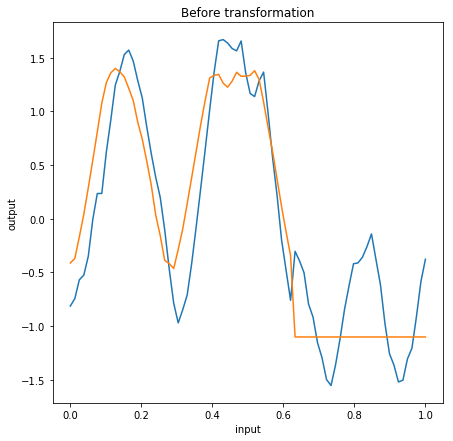

In [251]:
# Plot two selected time series
n = 0
m = 4
plt.figure(figsize=(7, 7))
plt.plot(np.linspace(0,1,ts_length), X_train[n], np.linspace(0,1,ts_length), X_train[m])
plt.xlabel('input')
plt.ylabel('output')
plt.title('Before transformation')

In [252]:
# Get indices for different classes
class_indices = {}

for label in range(num_classes):
    class_indices[label] = np.where( y_train == label )[0]
    
print(class_indices[0])
print(class_indices[1])

# Get pairs of indices for transformations
transformations_pairs = []

for label in range(num_classes):
    for n in range(train_size):
        for m in range(train_size):
            if n in class_indices[label] and m in class_indices[label]:
                transformations_pairs.append((n,m))

[  7   8  18  37  61  64  73  84  96  97  98 105 115 121 128 136 137 138]
[  0  13  21  35  62  75  77  83  88  92  93  99 103 111 114 119 125 130
 133]


In [253]:
with open('transformations/' + ds + '_transformations', 'rb') as f:
    ds_transformations_pkl = pickle.load(f)
    
print(ds_transformations_pkl)

[[ -2.46835974e-09  -1.09806830e-10   2.07434458e-10 ...,   4.21029878e-09
   -5.84587045e-10  -6.60652089e-10]
 [ -4.19048704e-02   6.85464451e-03  -1.45572973e-02 ...,   2.95986980e-02
    4.55396157e-03  -2.28020223e-03]
 [  8.82870145e-03  -2.20980067e-02   1.85987372e-02 ...,   8.49915016e-03
   -2.38904990e-02  -2.08202433e-02]
 ..., 
 [  1.75259095e-02  -1.71760358e-02   7.03342212e-03 ...,   1.46614583e-02
   -1.15230670e-02  -1.28034074e-02]
 [  1.12121599e-03   1.42907622e-04   5.92812710e-03 ...,  -8.43372196e-04
   -5.65883750e-03  -6.28759619e-03]
 [  2.83698093e-10   1.27361599e-09   5.50711310e-10 ...,  -1.04967502e-11
    2.15441720e-10   2.28268598e-10]]


In [254]:
print(len(transformations_pairs))
print(len(ds_transformations_pkl))

4203
4203


In [255]:
for i in range(len(transformations_pairs)):
    print(transformations_pairs[i], i)

(7, 7) 0
(7, 8) 1
(7, 18) 2
(7, 37) 3
(7, 61) 4
(7, 64) 5
(7, 73) 6
(7, 84) 7
(7, 96) 8
(7, 97) 9
(7, 98) 10
(7, 105) 11
(7, 115) 12
(7, 121) 13
(7, 128) 14
(7, 136) 15
(7, 137) 16
(7, 138) 17
(8, 7) 18
(8, 8) 19
(8, 18) 20
(8, 37) 21
(8, 61) 22
(8, 64) 23
(8, 73) 24
(8, 84) 25
(8, 96) 26
(8, 97) 27
(8, 98) 28
(8, 105) 29
(8, 115) 30
(8, 121) 31
(8, 128) 32
(8, 136) 33
(8, 137) 34
(8, 138) 35
(18, 7) 36
(18, 8) 37
(18, 18) 38
(18, 37) 39
(18, 61) 40
(18, 64) 41
(18, 73) 42
(18, 84) 43
(18, 96) 44
(18, 97) 45
(18, 98) 46
(18, 105) 47
(18, 115) 48
(18, 121) 49
(18, 128) 50
(18, 136) 51
(18, 137) 52
(18, 138) 53
(37, 7) 54
(37, 8) 55
(37, 18) 56
(37, 37) 57
(37, 61) 58
(37, 64) 59
(37, 73) 60
(37, 84) 61
(37, 96) 62
(37, 97) 63
(37, 98) 64
(37, 105) 65
(37, 115) 66
(37, 121) 67
(37, 128) 68
(37, 136) 69
(37, 137) 70
(37, 138) 71
(61, 7) 72
(61, 8) 73
(61, 18) 74
(61, 37) 75
(61, 61) 76
(61, 64) 77
(61, 73) 78
(61, 84) 79
(61, 96) 80
(61, 97) 81
(61, 98) 82
(61, 105) 83
(61, 115) 84
(61, 1

In [256]:
for val in ds_transformations_pkl[2]: # 6
    print(str(format(val, '.4g')) + ' \\\\')

print()

for val in ds_transformations_pkl[36]: # 60
    print(str(format(val, '.4g')) + ' \\\\')

0.008829 \\
-0.0221 \\
0.0186 \\
0.01522 \\
-0.007811 \\
0.02085 \\
0.02076 \\
0.0121 \\
0.008499 \\
-0.02389 \\
-0.02082 \\

-0.007169 \\
0.01344 \\
-0.01096 \\
-0.01928 \\
0.007395 \\
-0.02052 \\
-0.01921 \\
-0.0132 \\
-0.0104 \\
0.02602 \\
0.01782 \\


In [257]:
# Seperate transformations into classes
split_indices = []

for i in range(num_classes):
    split_indices.append(len(class_indices[i])**2)
    
split_indices = np.cumsum(split_indices)[:-1]

theta_classes = np.split(ds_transformations_pkl, split_indices)

In [258]:
# Clean set of transformations

# Remove NaNs
for i in range(num_classes):
    print(len(theta_classes[i]))
    theta_classes[i] = theta_classes[i][~np.isnan(theta_classes[i]).any(axis=1)]
    print(len(theta_classes[i]))

324
320
361
358
1521
1506
169
168
64
64
1764
1763


In [259]:
# Choose which class to examine
class_idx = 0

thetas = theta_classes[class_idx]

# Remove outliers
thetas = remove_outliers(thetas)

## PCA plot

In [260]:
# Perform principal component analysis/singular value decomposition
pca = PCA(n_components=None)
pca.fit(thetas)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [261]:
print(pca.singular_values_)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.components_)

[ 34.09662411  28.57232045  23.00812148  17.66413837  12.91908187
   6.88674277   6.16111888   5.23479834   3.57646614   2.48176435
   2.25918207]
[ 0.37213279  0.26131612  0.16944841  0.09987576  0.05342425  0.01518109
  0.01215051  0.00877152  0.00409434  0.0019715   0.00163372]
[ 0.37213279  0.63344891  0.80289732  0.90277307  0.95619733  0.97137842
  0.98352892  0.99230045  0.99639478  0.99836628  1.        ]
[[  7.55672527e-02   1.29753668e-01   1.77386893e-01   2.97220835e-01
    1.73772841e-01   2.78581245e-01   2.77009693e-01   2.88709736e-01
    1.52246645e-01   7.32287060e-01  -1.74159896e-01]
 [  8.62842878e-02   8.30015433e-01  -4.27105629e-01   6.71239005e-02
    1.34225744e-01  -1.41281871e-03   4.68157238e-02   9.95352389e-02
    9.68676334e-02  -1.29725460e-01   2.45713270e-01]
 [  2.28469666e-01  -1.90529894e-01   2.58703216e-01   1.84290384e-01
   -7.18073320e-02   2.87182685e-01   3.58886550e-01   1.62018866e-01
    6.93921303e-02  -2.66745737e-01   7.01399502e-01]
 

In [262]:
print(pca.get_covariance())

[[  1.74856443e-01   1.36638259e-01   7.83601058e-02   1.70485129e-01
    1.01463823e-01   1.38266062e-01   1.55966327e-01   2.10951021e-01
    1.27168831e-01   7.35691480e-02   2.92784849e-01]
 [  1.36638259e-01   1.91695303e+00  -9.07969889e-01   2.13106513e-01
    3.67033334e-01   6.00212096e-02   1.40404803e-01   2.81294568e-01
    2.47361148e-01   1.56443467e-01   2.11260982e-01]
 [  7.83601058e-02  -9.07969889e-01   7.65766707e-01   1.90276283e-01
   -2.90137592e-02   2.33581276e-01   1.65263512e-01   2.22006335e-01
    7.68660195e-02   5.26482206e-01  -2.85479316e-02]
 [  1.70485129e-01   2.13106513e-01   1.90276283e-01   8.02906456e-01
   -2.02383395e-03   2.37921921e-01   2.46156135e-01   4.16558649e-01
    2.79990072e-01   6.77332349e-01   7.14718837e-02]
 [  1.01463823e-01   3.67033334e-01  -2.90137592e-02  -2.02383395e-03
    3.96462436e-01   1.31604064e-01   1.26754024e-01   2.57112037e-01
    1.41651184e-01   4.66344233e-01  -6.78252987e-02]
 [  1.38266062e-01   6.0021209

In [263]:
print(np.cov(thetas, rowvar=False))

[[  1.74856443e-01   1.36638259e-01   7.83601058e-02   1.70485129e-01
    1.01463823e-01   1.38266062e-01   1.55966327e-01   2.10951021e-01
    1.27168831e-01   7.35691480e-02   2.92784849e-01]
 [  1.36638259e-01   1.91695303e+00  -9.07969889e-01   2.13106513e-01
    3.67033334e-01   6.00212096e-02   1.40404803e-01   2.81294568e-01
    2.47361148e-01   1.56443467e-01   2.11260982e-01]
 [  7.83601058e-02  -9.07969889e-01   7.65766707e-01   1.90276283e-01
   -2.90137592e-02   2.33581276e-01   1.65263512e-01   2.22006335e-01
    7.68660195e-02   5.26482206e-01  -2.85479316e-02]
 [  1.70485129e-01   2.13106513e-01   1.90276283e-01   8.02906456e-01
   -2.02383395e-03   2.37921921e-01   2.46156135e-01   4.16558649e-01
    2.79990072e-01   6.77332349e-01   7.14718837e-02]
 [  1.01463823e-01   3.67033334e-01  -2.90137592e-02  -2.02383395e-03
    3.96462436e-01   1.31604064e-01   1.26754024e-01   2.57112037e-01
    1.41651184e-01   4.66344233e-01  -6.78252987e-02]
 [  1.38266062e-01   6.0021209

In [72]:
print(pca.mean_)

[ 0.04257387  0.11390307 -0.00334819  0.06662547 -0.02839988  0.09536583
  0.0769281   0.07720254  0.02625744  0.0039462   0.10354593]


In [73]:
print(np.amax(thetas,axis=0))

[  6.38070822  14.03785992  10.18192673  12.36540222   7.19300938
   7.67183685   9.86941147  11.17961216   6.65729713  13.02931976
  17.3488903 ]


In [74]:
# Project theta data on first two principal components
pca = PCA(n_components=2)
thetas_pca = pca.fit_transform(thetas)

print(thetas.shape)
print(thetas_pca.shape)

(317, 11)
(317, 2)


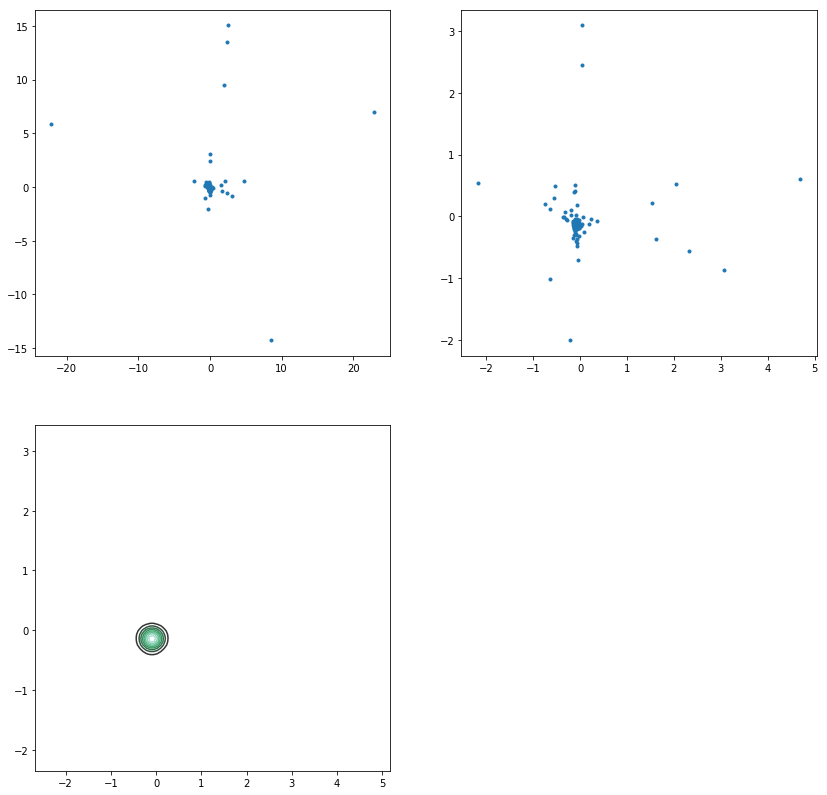

In [75]:
# Plot pca projections
data = thetas_pca[:,[0,1]]

x = thetas_pca[:,0]
y = thetas_pca[:,1]

plt.figure(figsize=(14, 14))

plt.subplot(221)
plt.plot(x,y,'.')

data = remove_outliers(data)
x = data[:,0]
y = data[:,1]

plt.subplot(222)
plt.plot(x,y,'.')

plt.subplot(223)
sns.kdeplot(x, y)

plt.show()

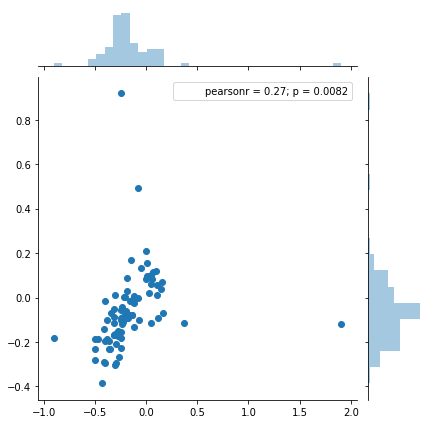

In [140]:
plt.figure(figsize=(7, 7))
sns.jointplot(x=x, y=y)
plt.show()

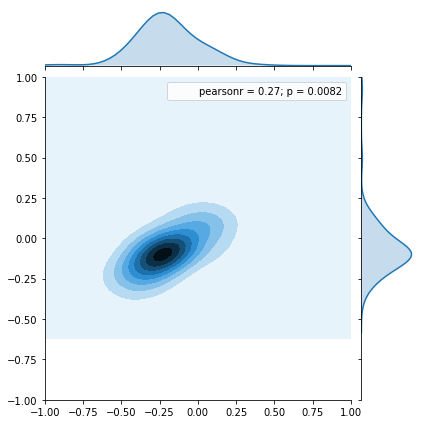

In [141]:
plt.figure(figsize=(7, 7))

sns.jointplot(x=x, y=y, kind="kde", xlim=(-1,1), ylim=(-1,1))
#kind='hex' / kde


#plt.savefig("pca_normal_2.eps", bbox_inches='tight')
plt.show()

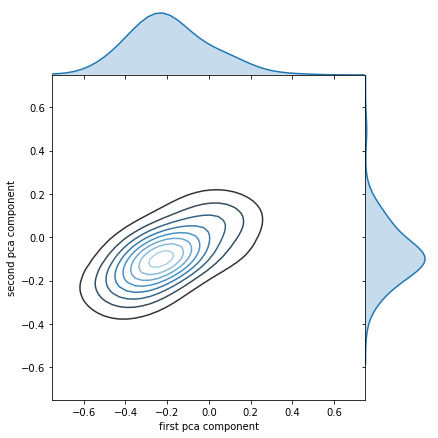

In [146]:
g = sns.JointGrid(x=x, y=y, space=0, xlim=(-0.75,0.75), ylim=(-0.75,0.75))
g = g.plot_joint(sns.kdeplot, cmap="Blues_d")
g = g.plot_marginals(sns.kdeplot, shade=True)
g = g.set_axis_labels('first pca component','second pca component')

#g.savefig("pca_normal_1.eps", bbox_inches='tight')

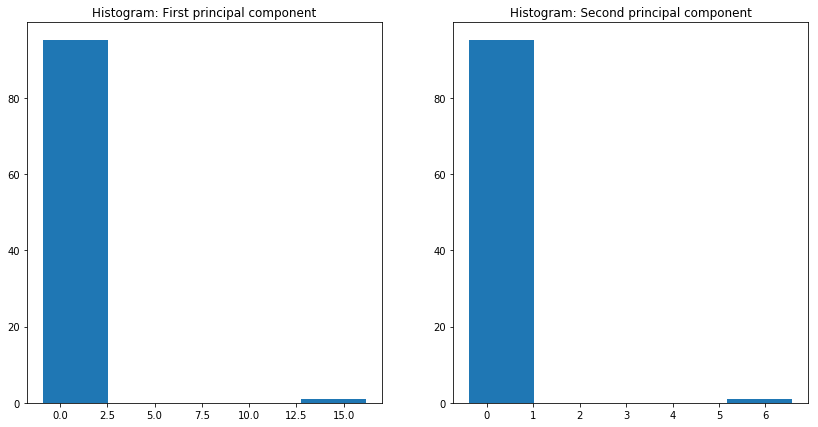

In [48]:
# Plot histograms of first two principal components
x = thetas_pca[:,0]
y = thetas_pca[:,1]

plt.figure(figsize=(14, 7))

plt.subplot(121)
plt.hist(x, bins=5)
plt.title("Histogram: First principal component")

plt.subplot(122)
plt.hist(y, bins=5)
plt.title("Histogram: Second principal component")

plt.show()

96
32


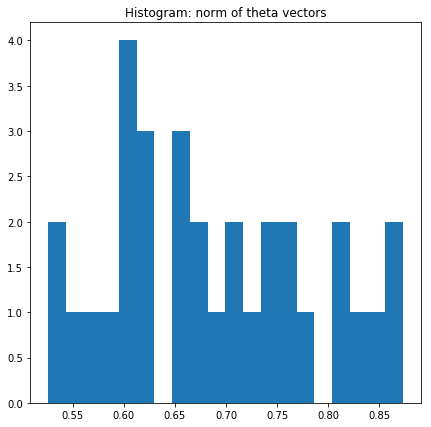

In [49]:
# Plot histogram of norm of theta vectors

# Compute norms
theta_norms = LA.norm(thetas, axis=1)

# Remove outliers
print(len(theta_norms))
theta_norms = theta_norms[abs(theta_norms - np.mean(theta_norms)) < 0.1 * np.std(theta_norms)]
print(len(theta_norms))

# Plot
plt.figure(figsize=(7, 7))
plt.hist(theta_norms, bins=20)
plt.title("Histogram: norm of theta vectors")
plt.show()

## Static animation

#### Along first principal component

In [19]:
# Fetch eigenvalue and eigenvector as explained variance and pca component
pca_i = 1
lambda_1 = pca.explained_variance_ratio_[pca_i-1]
v_1 = pca.components_[pca_i-1]

print(lambda_1)
print(v_1)

alpha = np.array([-3, -1.5, 1.5, 3])
Theta = np.outer(alpha,lambda_1 * v_1)

print(Theta.shape)

0.797336326443
[-0.09415823  0.44672693  0.84694451 -0.1374784  -0.22951284 -0.00686091
  0.01360702  0.01007364  0.01824123 -0.03554839 -0.02734393]
(4, 11)


In [20]:
# Number of intervals and number of cell intersections
N_p = 10
N_v = N_p + 1

N_step = 100

# Generate tesselation in 1D
tess = np.linspace(0,1,N_v)

# Generate L
L = generate_L(N_p)

# Find basis for null(L)
B = nullspace(L)
[D,d] = B.shape

In [21]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
# Sample a data point
x = np.linspace(0,1,ts_length)
data_point = X_train[7]

# Transform data point at chosen standard deviations of the principal components
data_point_trans = np.zeros((len(Theta), ts_length))

for i in range(len(Theta)):
    # Compute A matrix
    A = np.matmul(B, Theta[i])

    # Transform time series
    x_trans = transformation_v1(tess, A, x, N_step, N_p)

    # Interpolate values to correct interval
    x_trans_resc = (x_trans - np.amin(x_trans)) / (np.amax(x_trans) - np.amin(x_trans))
    data_point_trans[i] = np.interp(x, x_trans_resc, data_point)

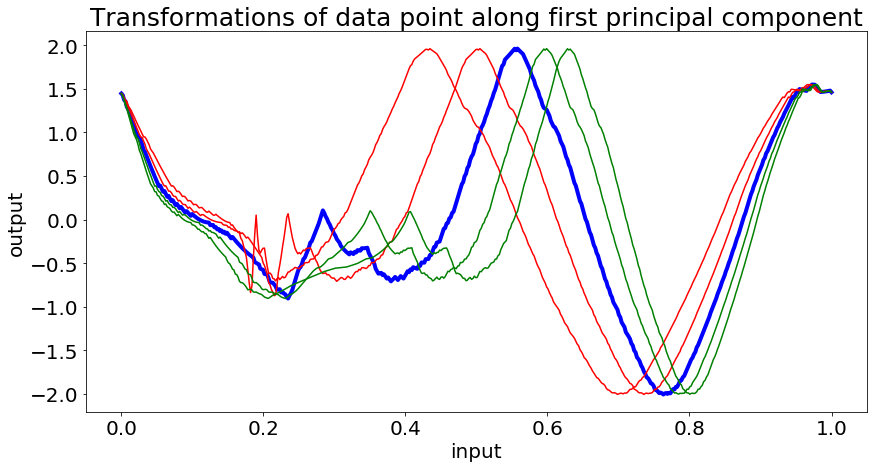

In [23]:
# Plot static animation

plt.figure(figsize=(14, 7))
plt.plot(x, data_point, color='b', linewidth=4)
plt.xlabel('input', fontsize=20)
plt.ylabel('output', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Transformations of data point along first principal component', fontsize=25)

for i in range(len(alpha)):
    if alpha[i] < 0:
        plt.plot(x, data_point_trans[i], color='r', linewidth=1.5)
    else:
        plt.plot(x, data_point_trans[i], color='g', linewidth=1.5)

#plt.savefig("data_first_pca_1.eps", bbox_inches='tight')
plt.show()

#### Along all principal components

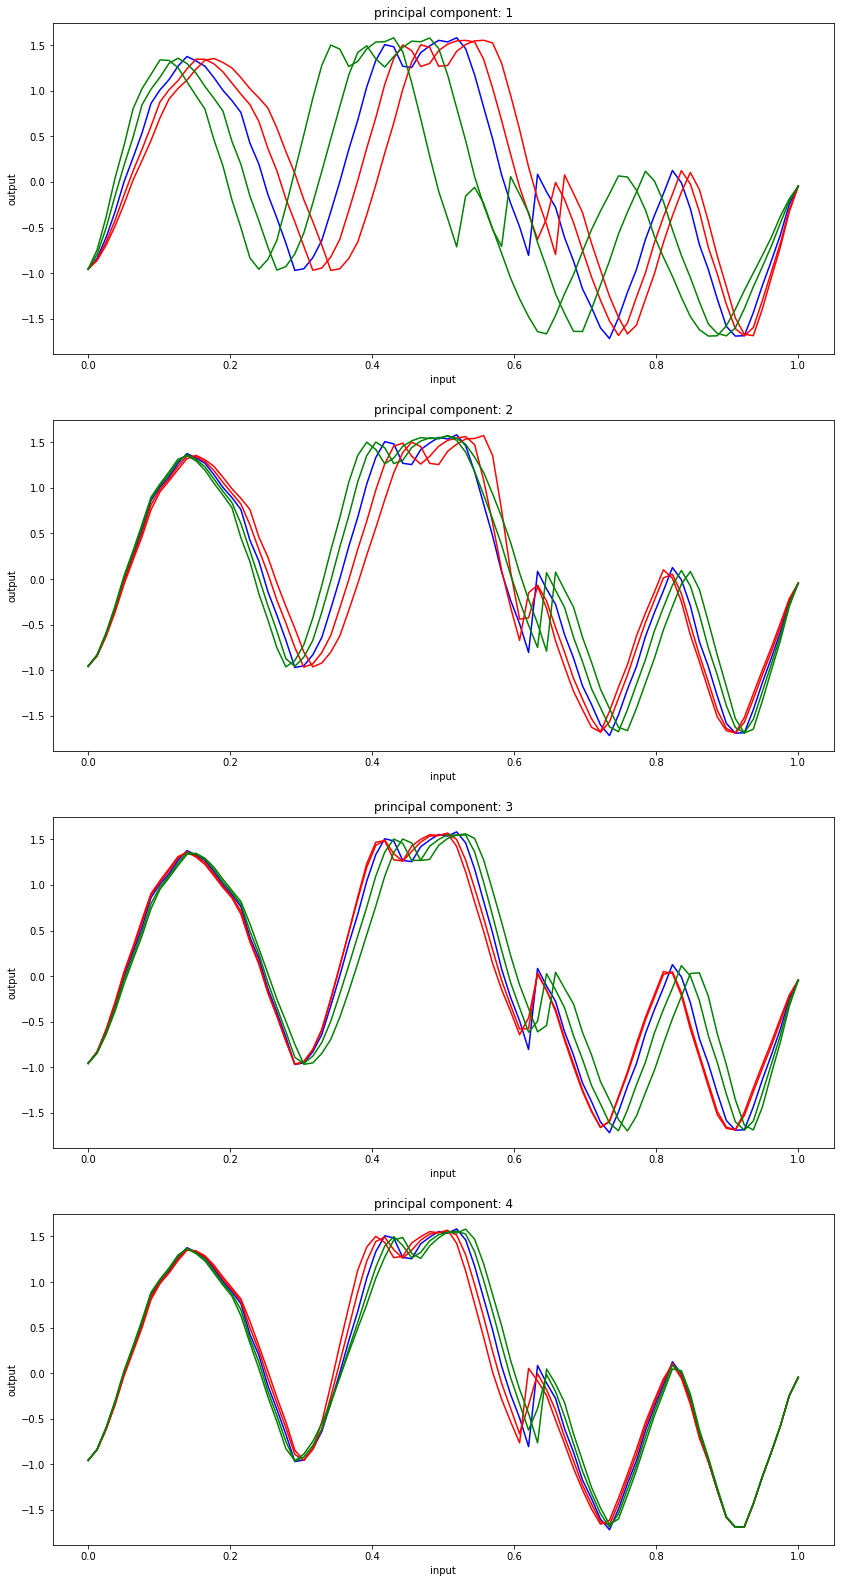

In [216]:
plt.figure(figsize=(14, 28))

for pca_i in range(1,5):
    # ----------------------------------------------------------------------------------------------------
    
    # Fetch eigenvalue and eigenvector as explained variance and pca component
    lambda_1 = pca.explained_variance_ratio_[pca_i-1]
    v_1 = pca.components_[pca_i-1]

    alpha = np.array([-3, -1.5, 1.5, 3])
    Theta = np.outer(alpha,lambda_1 * v_1)

    # ----------------------------------------------------------------------------------------------------

    # Transform data point at chosen standard deviations of the principal components
    data_point_trans = np.zeros((len(Theta), ts_length))

    for i in range(len(Theta)):
        # Compute A matrix
        A = np.matmul(B, Theta[i])

        # Transform time series
        x_trans = transformation_v1(tess, A, x, N_step, N_p)

        # Interpolate values to correct interval
        x_trans_resc = (x_trans - np.amin(x_trans)) / (np.amax(x_trans) - np.amin(x_trans))
        data_point_trans[i] = np.interp(x, x_trans_resc, data_point)

    # ----------------------------------------------------------------------------------------------------

    # Plot static animation
    plt.subplot(410+pca_i)
    plt.plot(x, data_point, color='b')
    plt.xlabel('input')
    plt.ylabel('output')
    plt.title('principal component: ' + str(pca_i))

    for i in range(len(alpha)):
        if alpha[i] < 0:
            plt.plot(x, data_point_trans[i], color='r')
        else:
            plt.plot(x, data_point_trans[i], color='g')
            
    # ----------------------------------------------------------------------------------------------------

plt.show()

## Animation

In [264]:
# Fetch eigenvalue and eigenvector as explained variance and pca component
i = 1
lambda_1 = pca.explained_variance_ratio_[i-1]
v_1 = pca.components_[i-1]

print(lambda_1)
print(v_1)

alpha = np.linspace(-3,3,50)
Theta = np.outer(alpha,lambda_1 * v_1)

0.372132788269
[ 0.07556725  0.12975367  0.17738689  0.29722083  0.17377284  0.27858125
  0.27700969  0.28870974  0.15224665  0.73228706 -0.1741599 ]


In [265]:
# Number of intervals and number of cell intersections
N_p = 10
N_v = N_p + 1

N_step = 100

# Generate tesselation in 1D
tess = np.linspace(0,1,N_v)

# Generate L
L = generate_L(N_p)

# Find basis for null(L)
B = nullspace(L)
[D,d] = B.shape

In [266]:
Theta = np.outer(alpha,lambda_1 * v_1)
print(Theta.shape)
print(Theta[0])

(50, 11)
[-0.08436316 -0.14485678 -0.19803444 -0.33181685 -0.19399972 -0.31100765
 -0.30925317 -0.32231508 -0.16996791 -0.81752408  0.19443182]


In [267]:
# Sample a data point
x = np.linspace(0,1,ts_length)
data_point = X_train[7] #X_train[7] X_train[4] X_train[5]

# Transform data point along plus-minus 3 standard deviations of the first principal component
data_point_trans = np.zeros((len(Theta), ts_length))
for i in range(len(Theta)):
    # Compute A matrix
    A = np.matmul(B, Theta[i])

    # Transform time series
    x_trans = transformation_v1(tess, A, x, N_step, N_p)

    # Interpolate values to correct interval
    x_trans_resc = (x_trans - np.amin(x_trans)) / (np.amax(x_trans) - np.amin(x_trans))
    data_point_trans[i] = np.interp(x, x_trans_resc, data_point)

(-0.050000000000000003, 1.05, -1.7496349999999998, 2.0351349999999999)

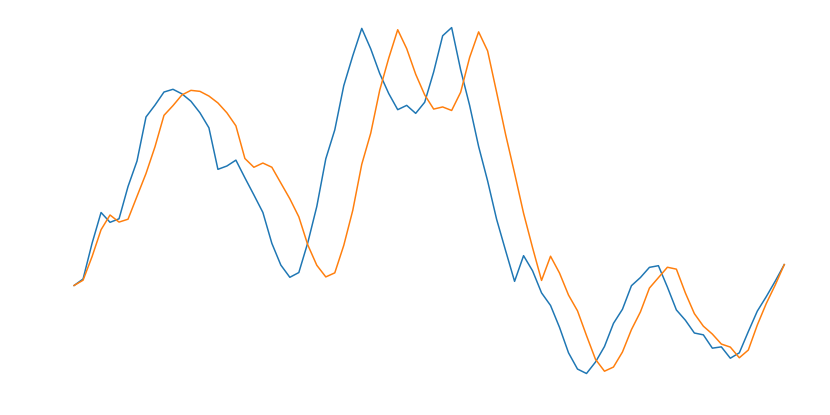

In [268]:
plt.figure(figsize=(14, 7))
plt.plot(x, data_point, x, data_point_trans[0])
plt.axis('off')

/Users/tobiasslottjensen/tensorflow_venv/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


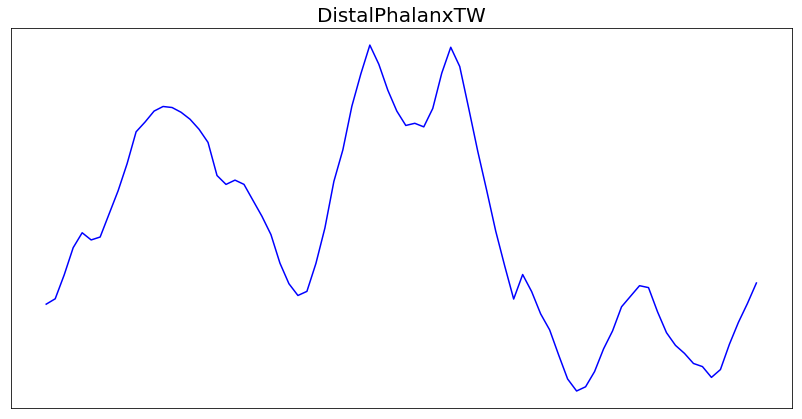

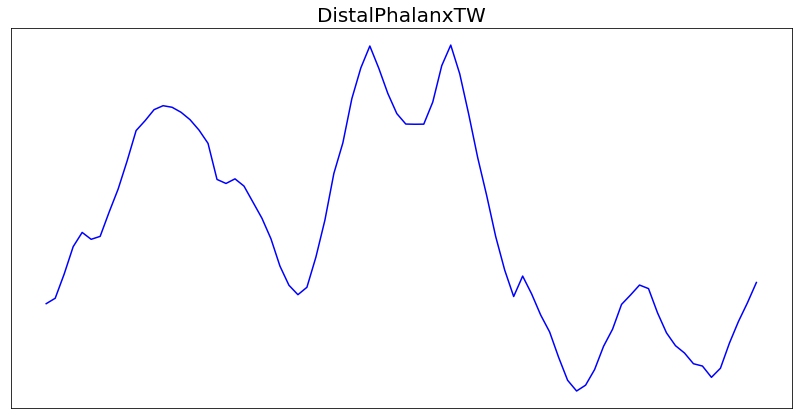

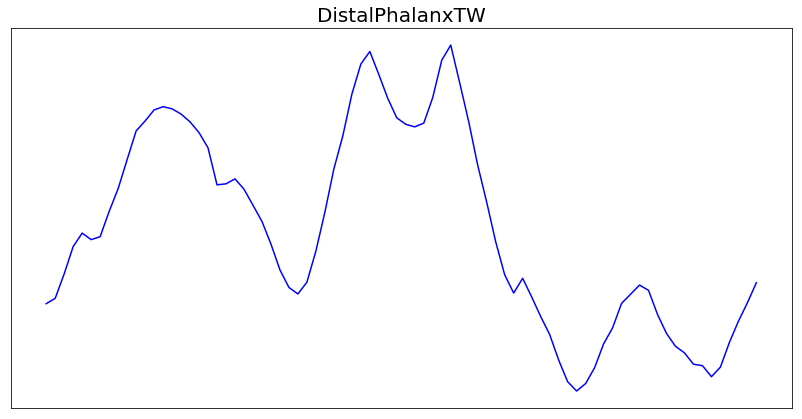

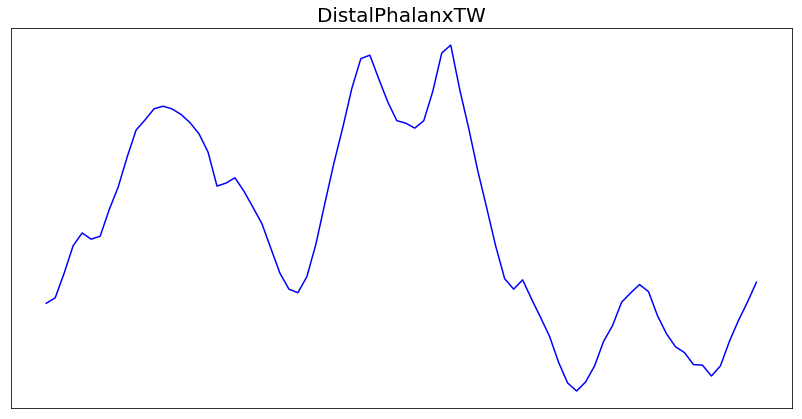

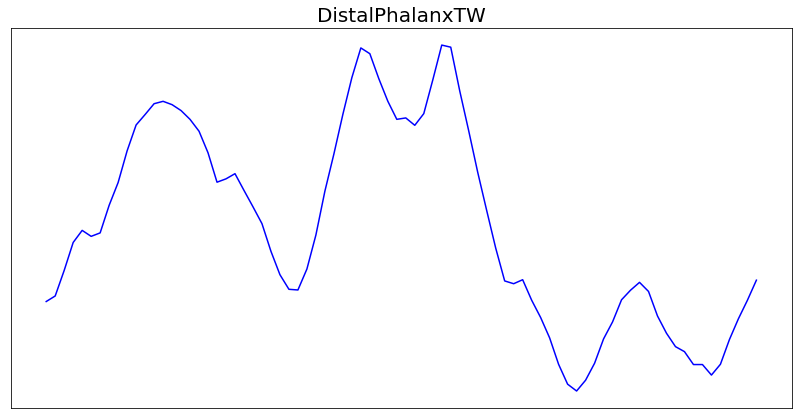

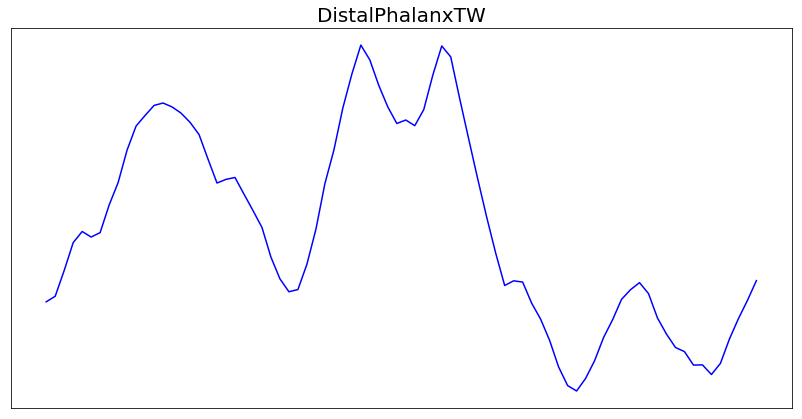

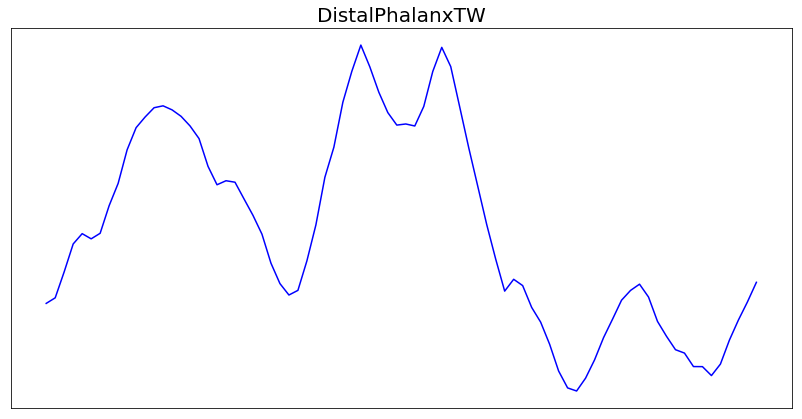

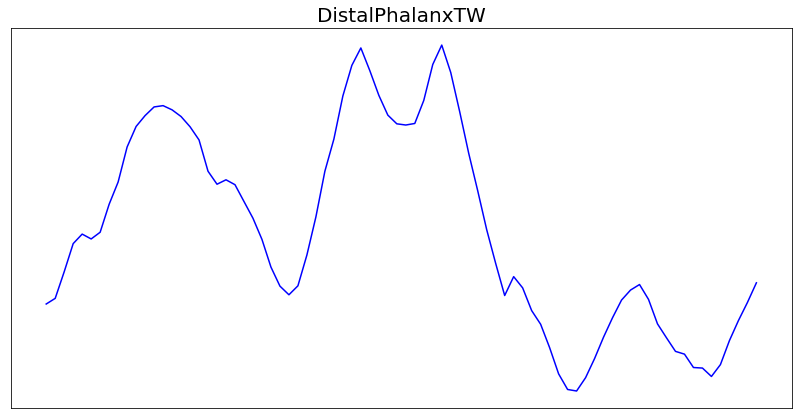

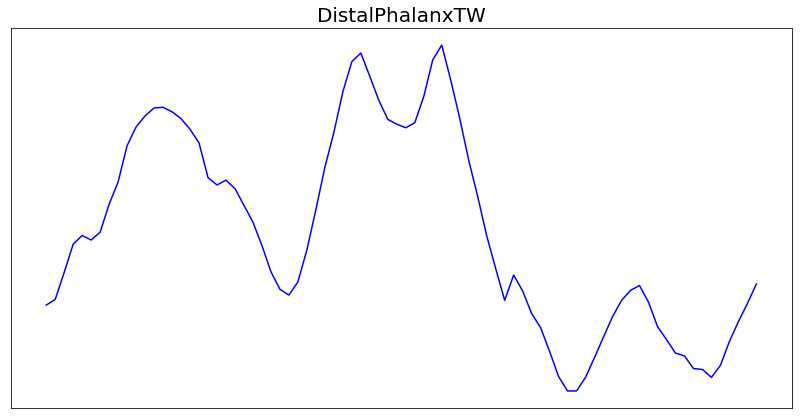

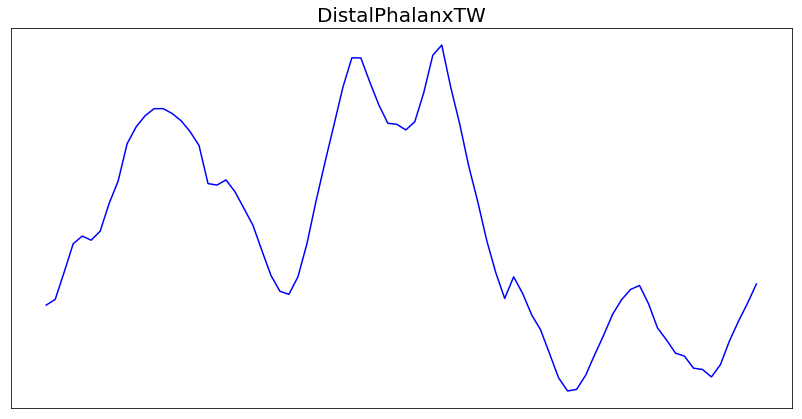

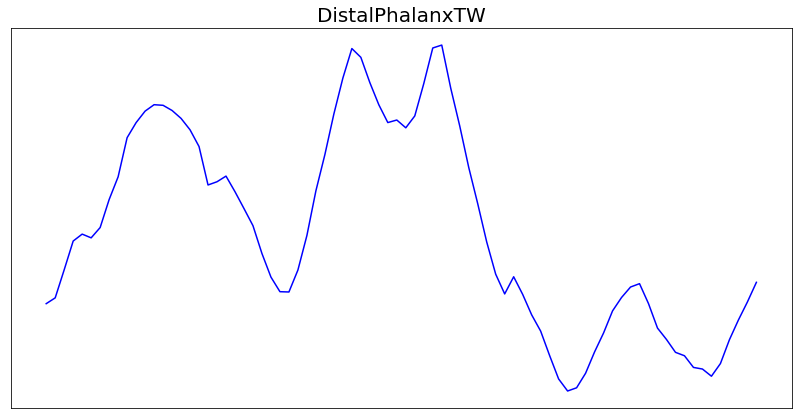

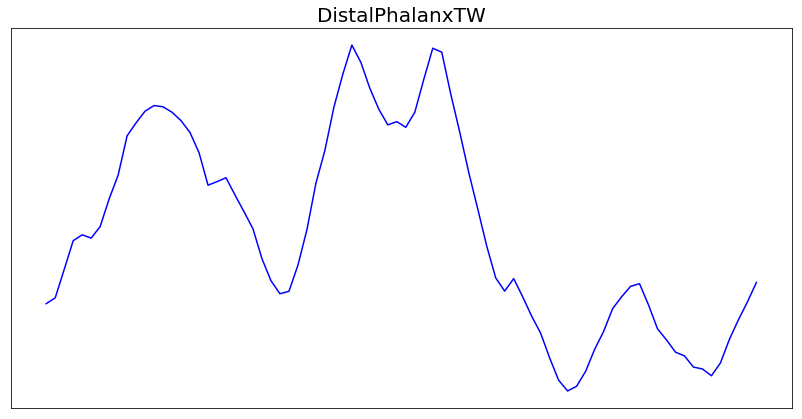

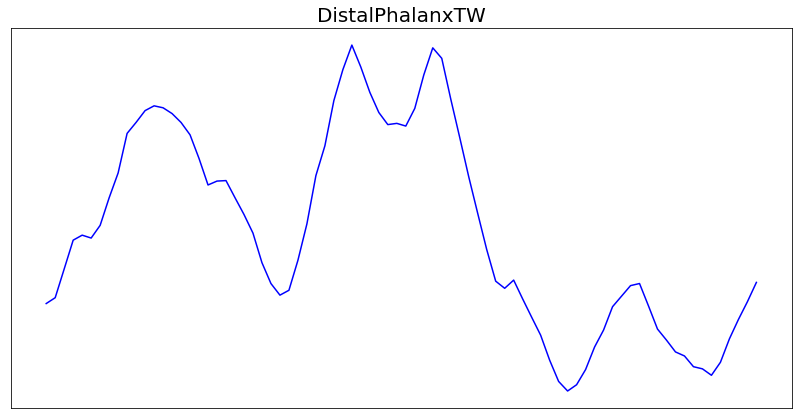

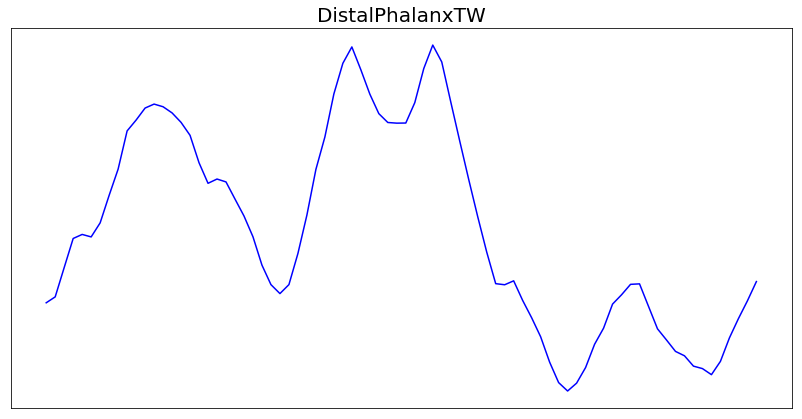

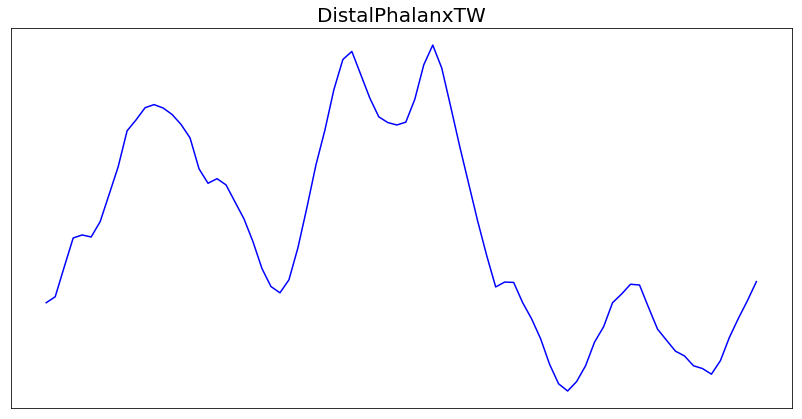

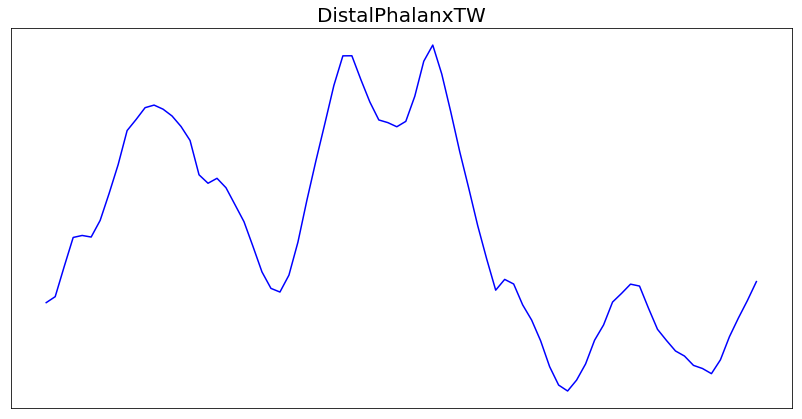

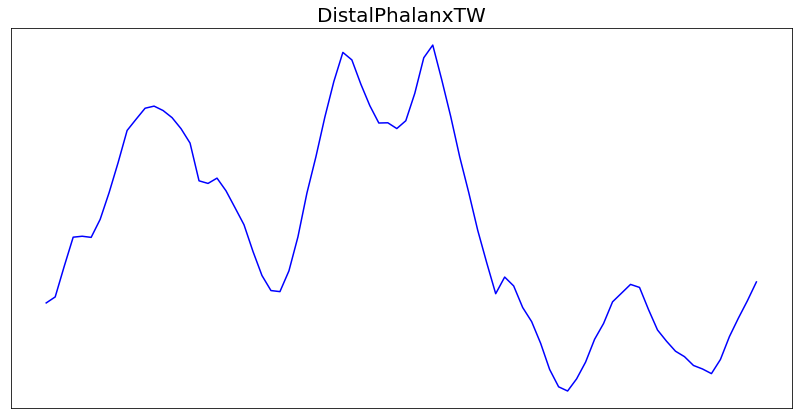

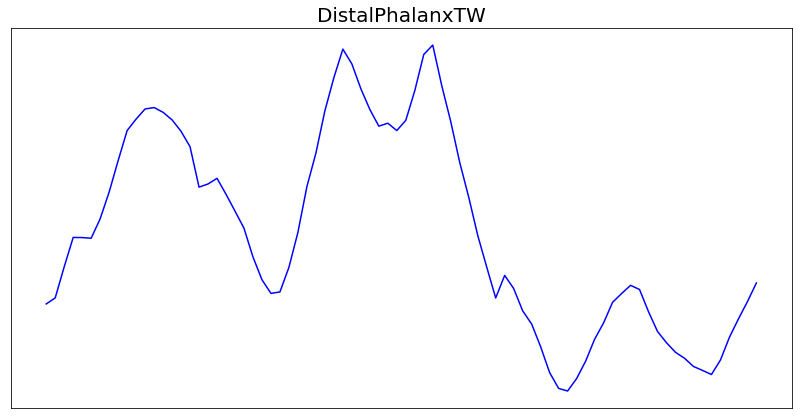

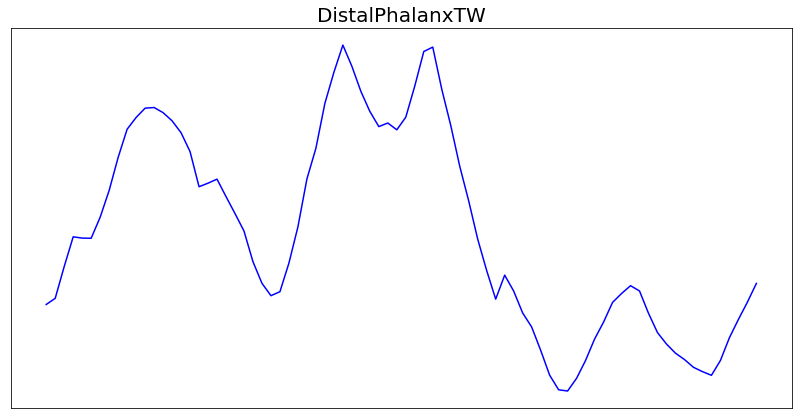

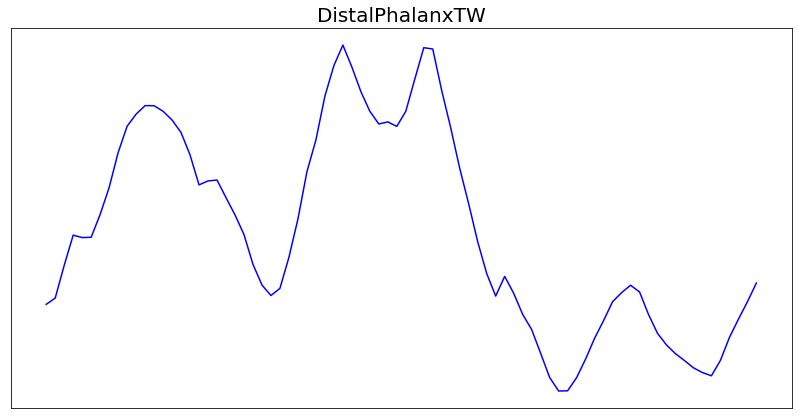

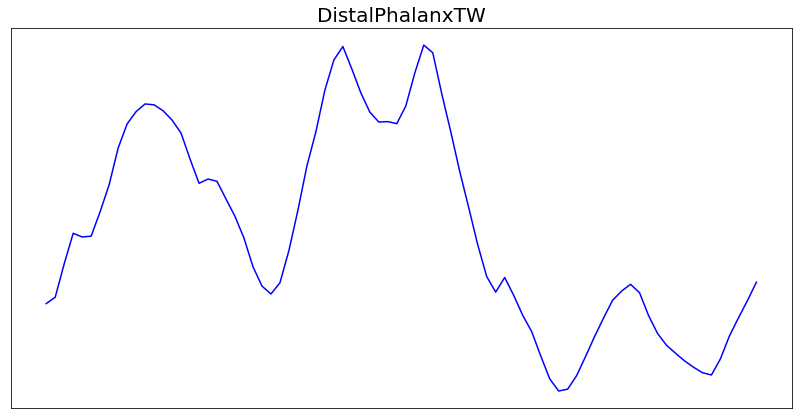

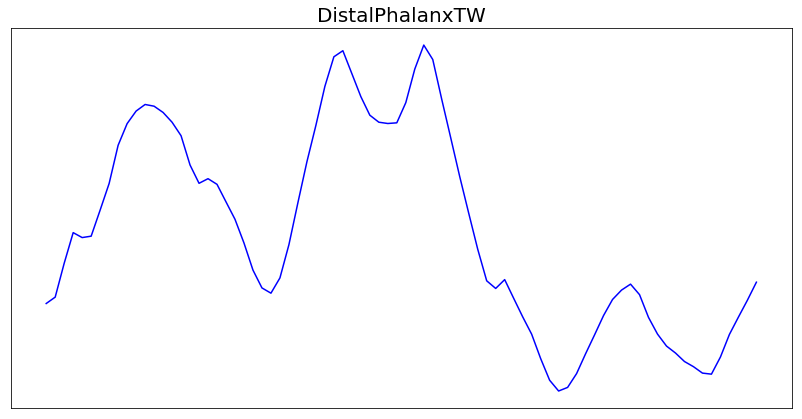

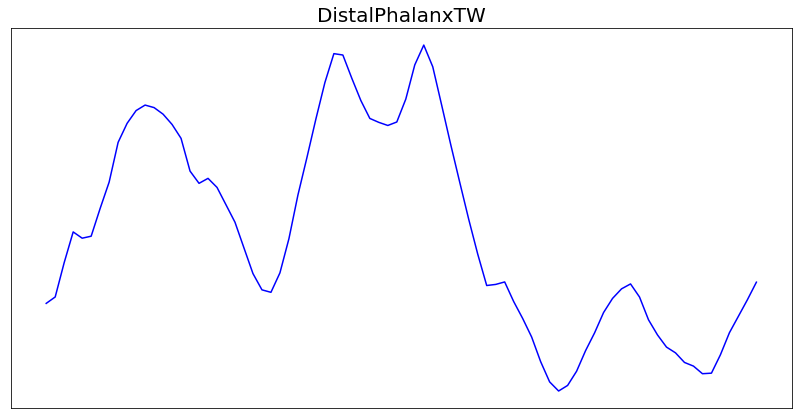

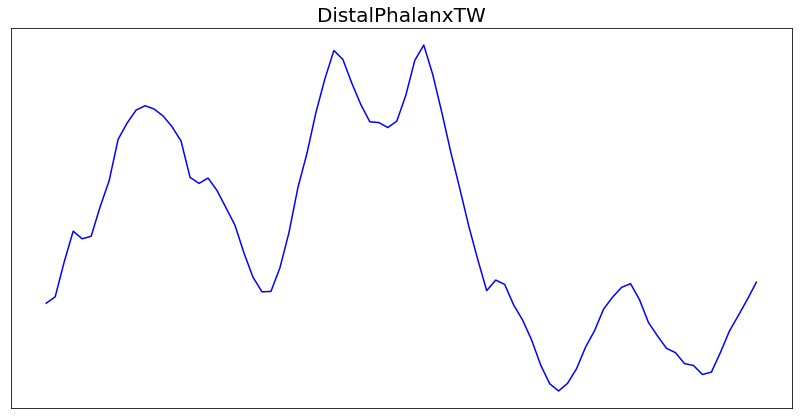

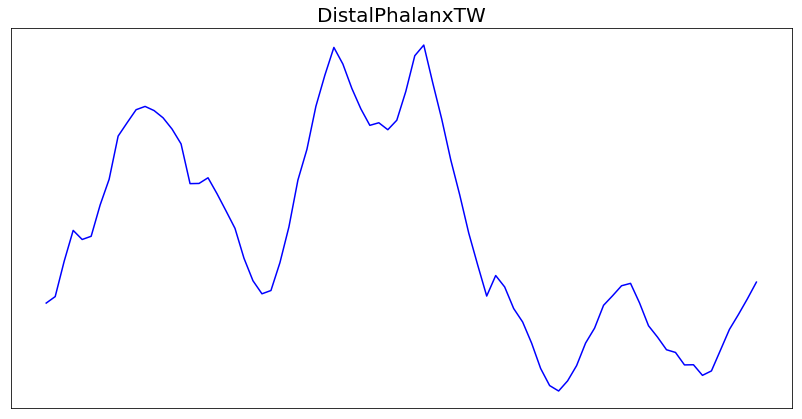

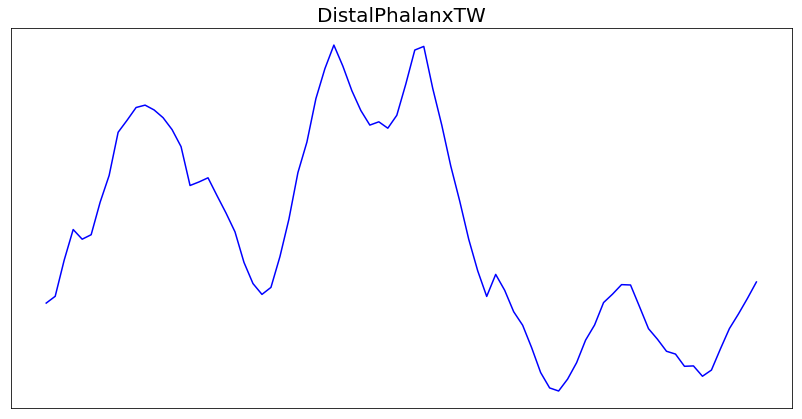

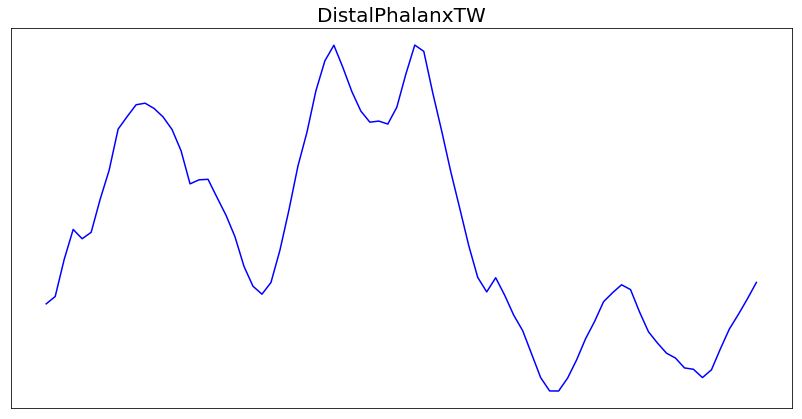

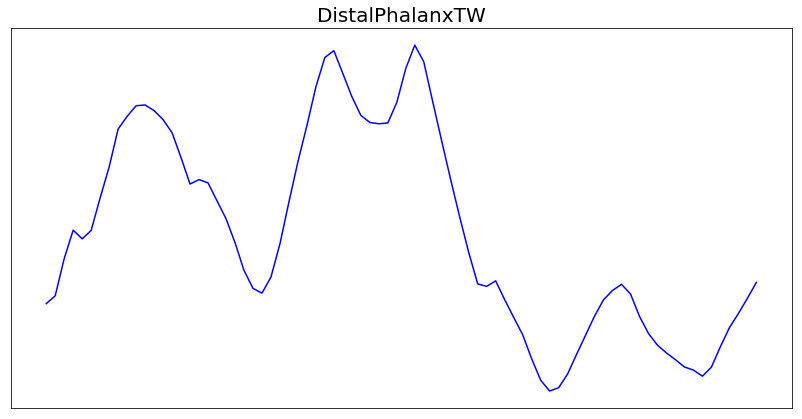

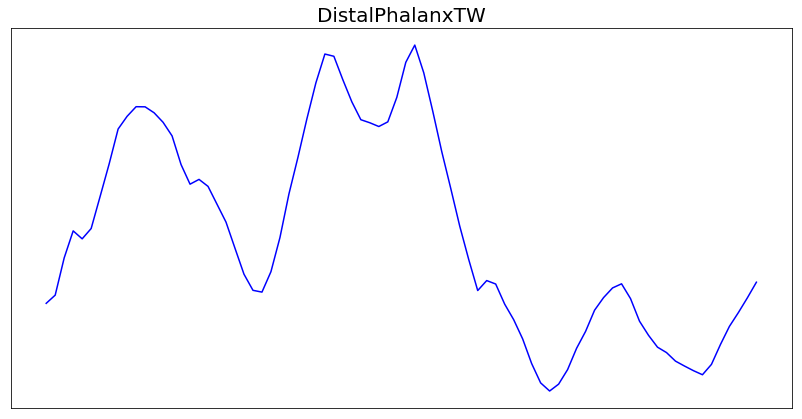

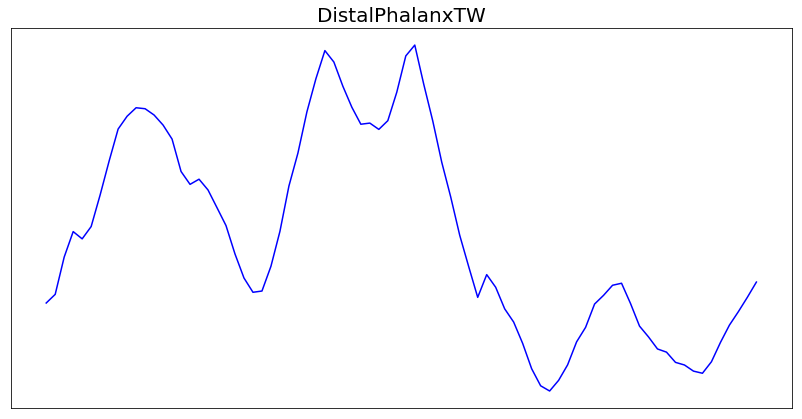

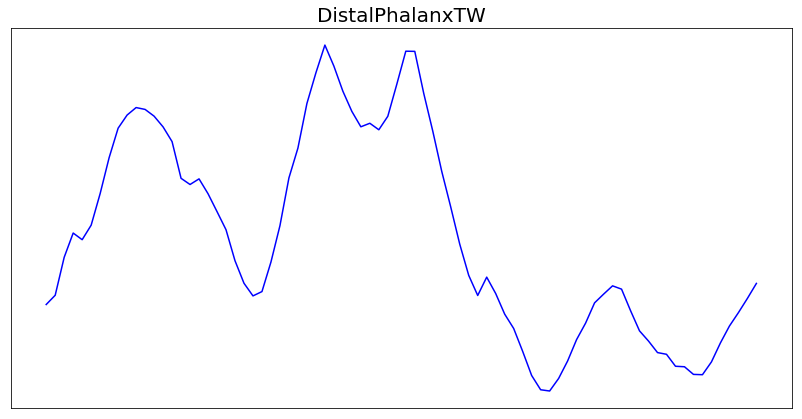

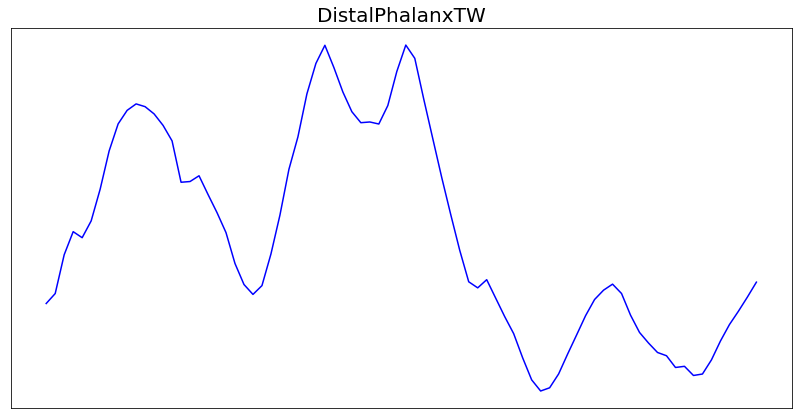

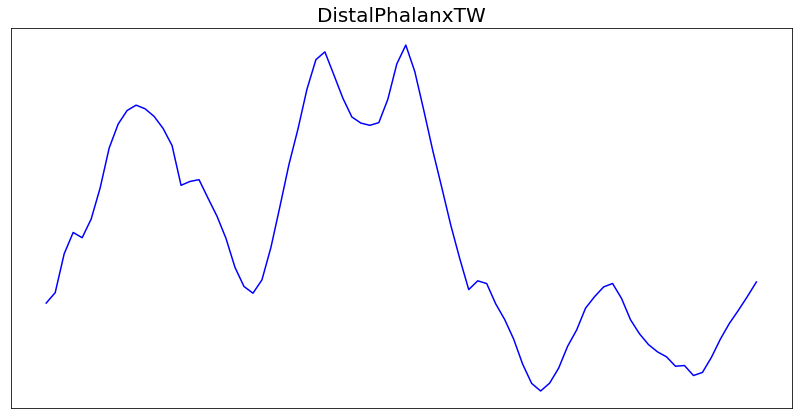

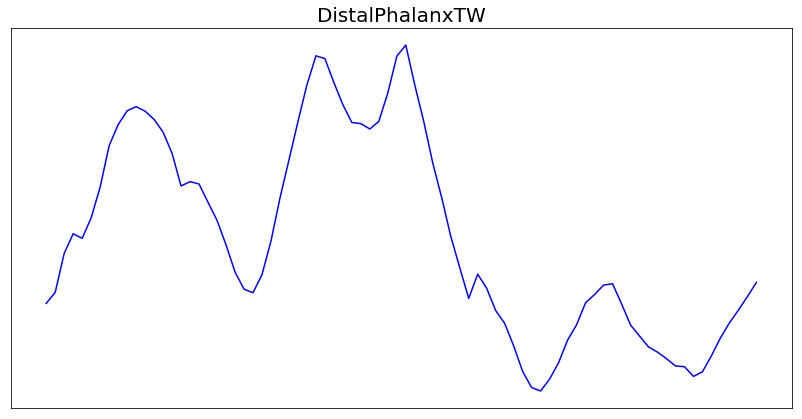

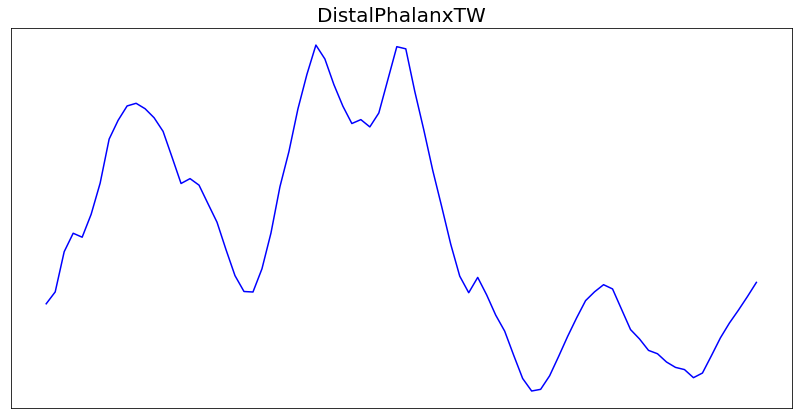

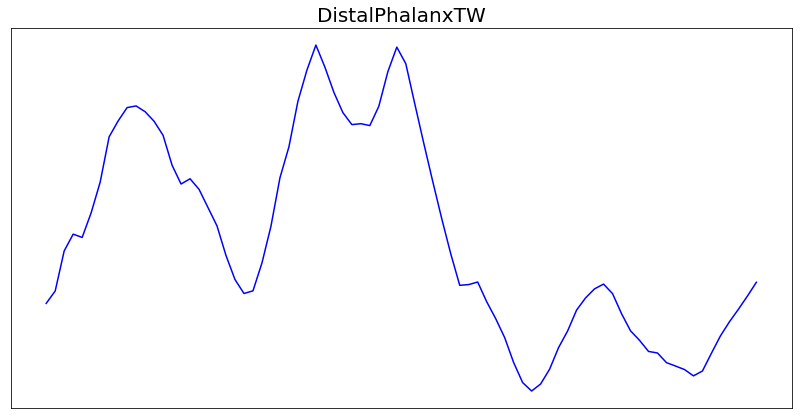

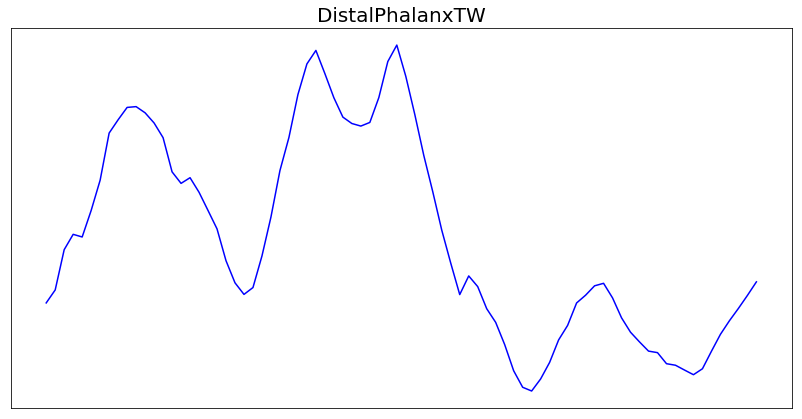

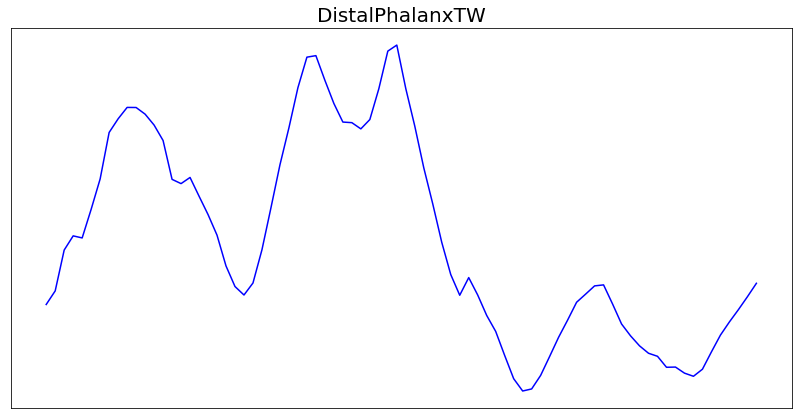

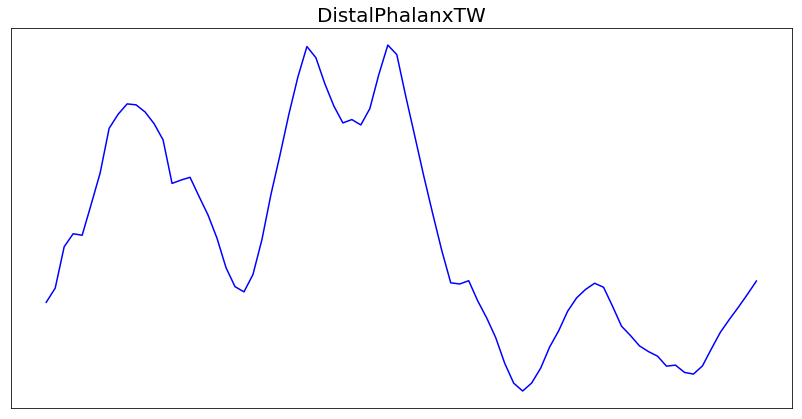

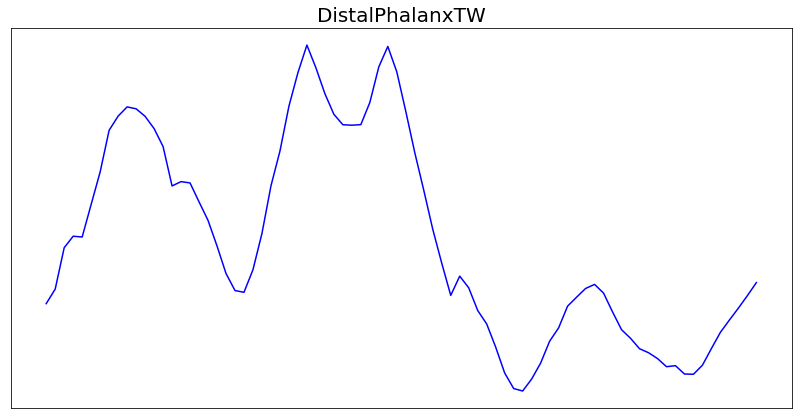

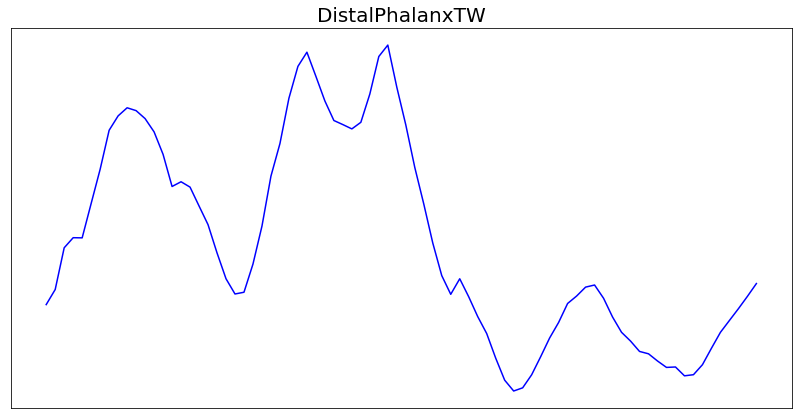

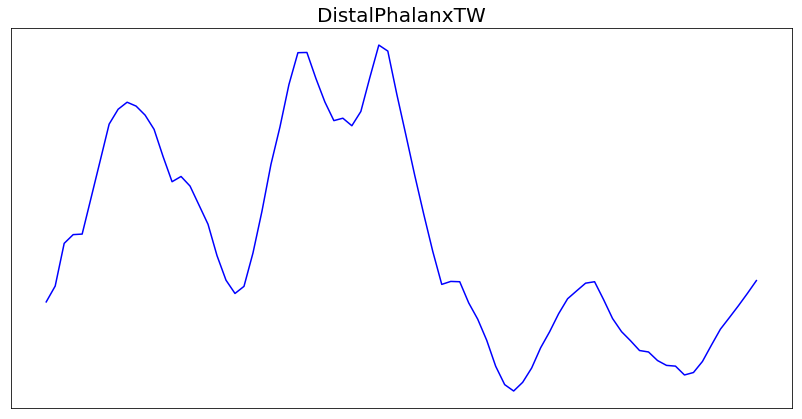

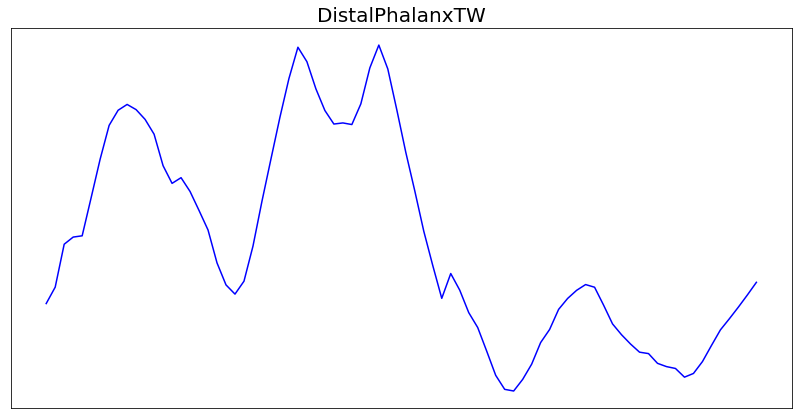

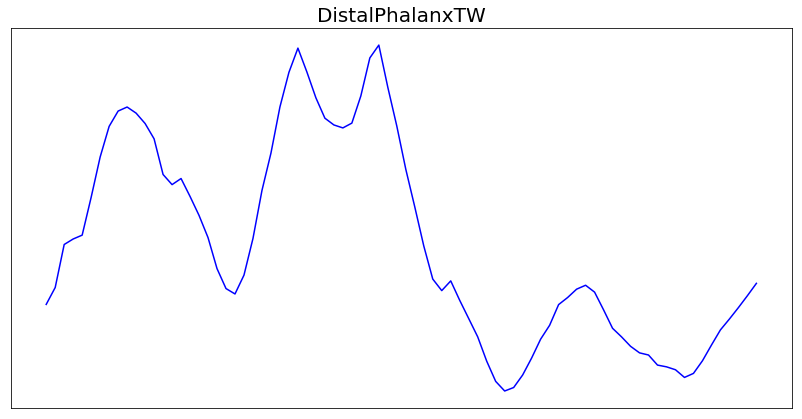

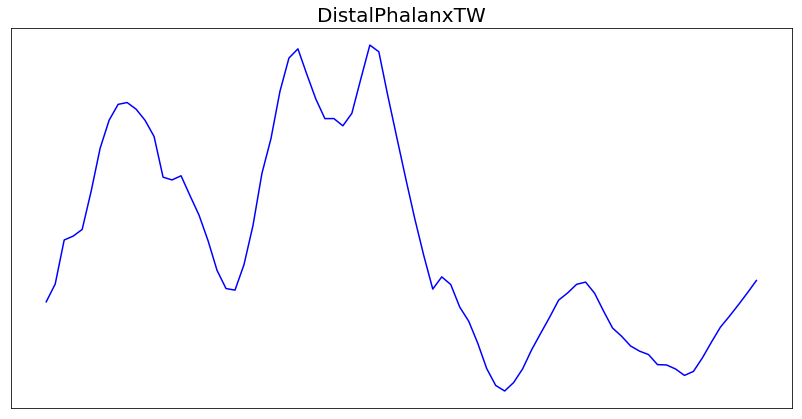

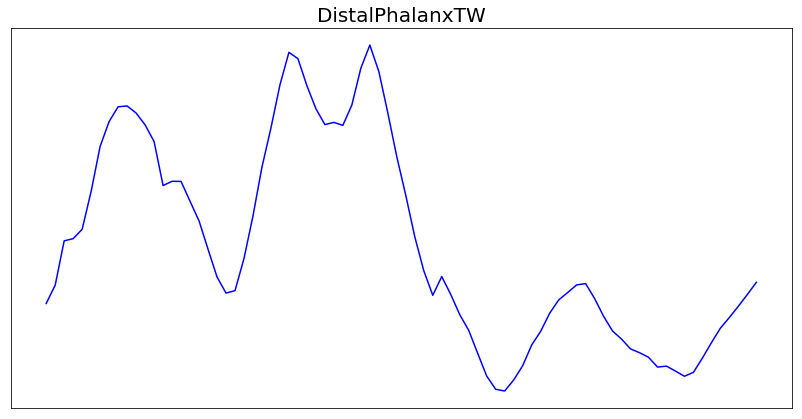

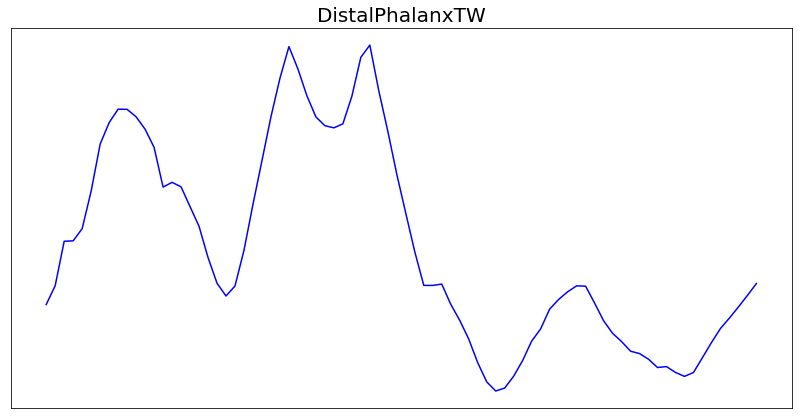

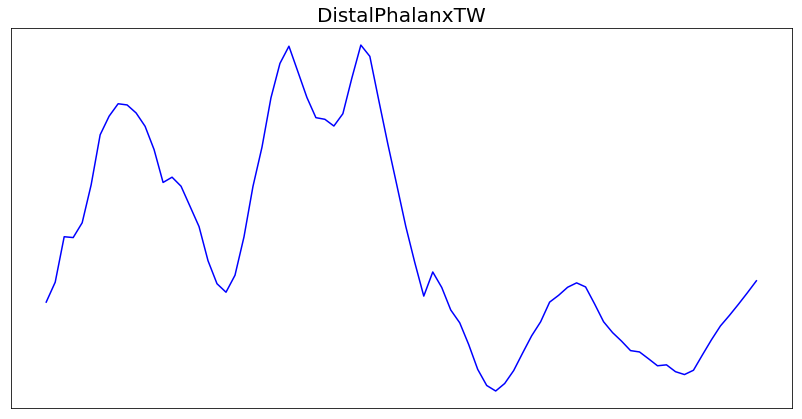

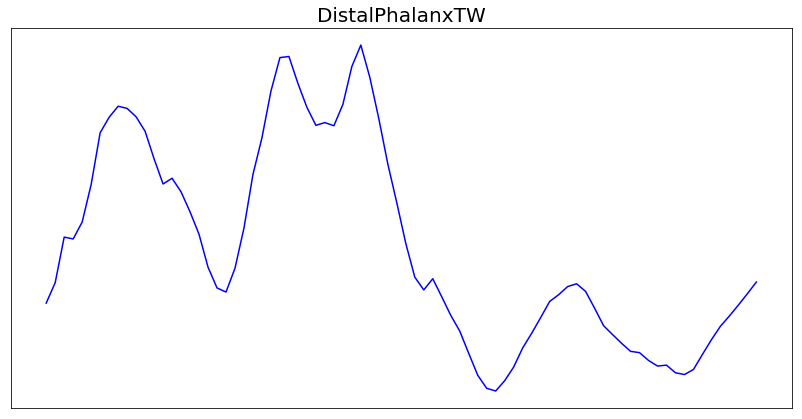

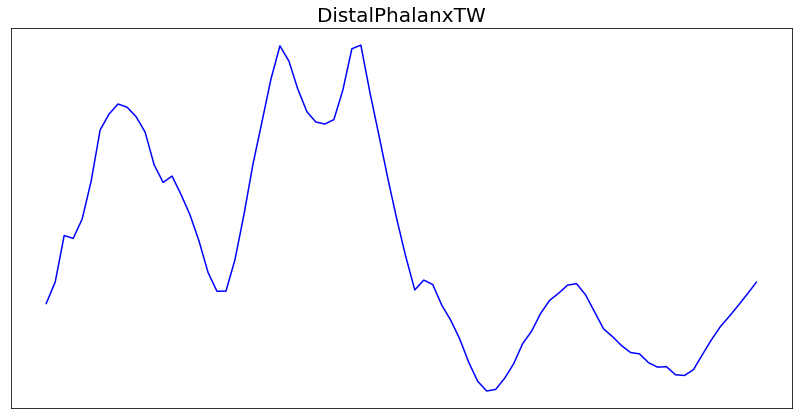

In [269]:
count = 300

for i in range(len(Theta)):
    plt.figure(figsize=(14, 7))
    plt.plot(x, data_point_trans[i], color='b', linewidth=1.5)
    plt.title(ds, fontsize=20)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("slides_anim_imgs/frame_" + str(count) + ".eps", bbox_inches='tight')
    count += 1

/Users/tobiasslottjensen/tensorflow_venv/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


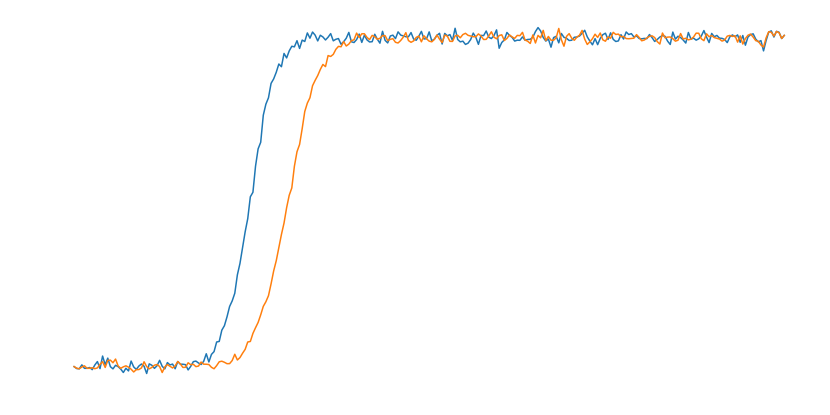

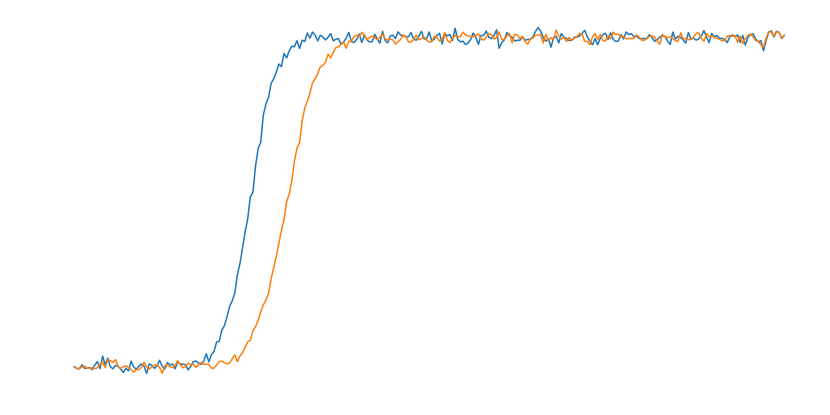

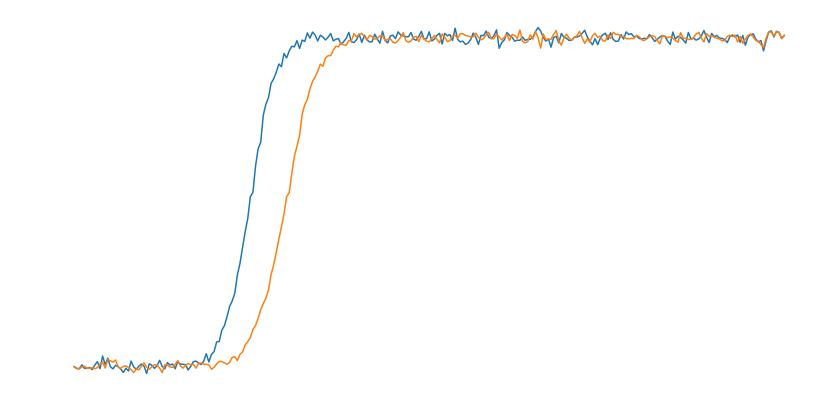

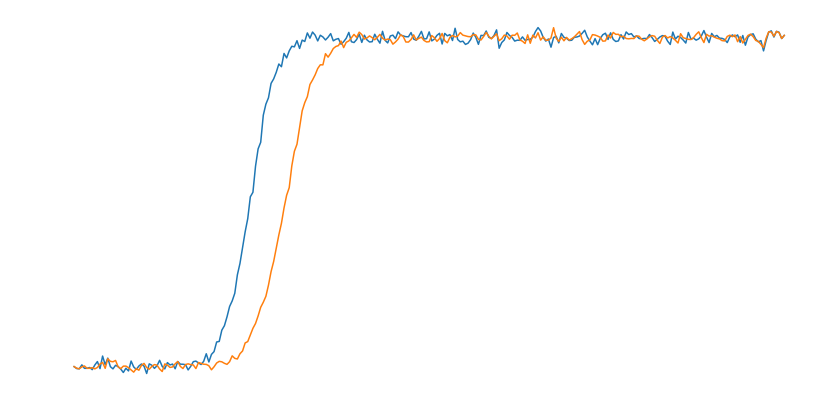

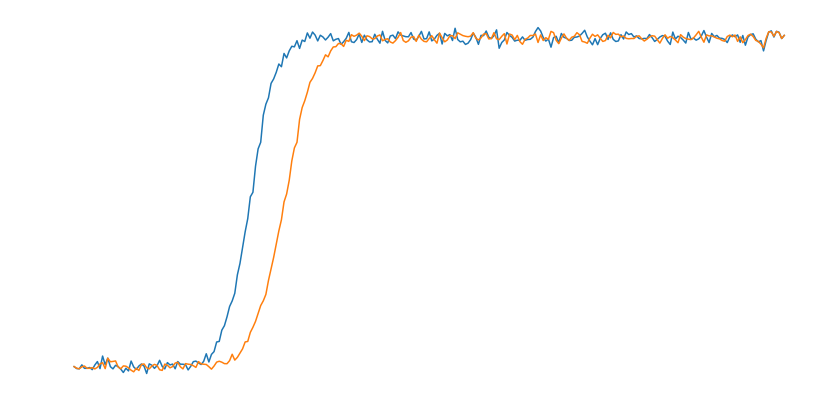

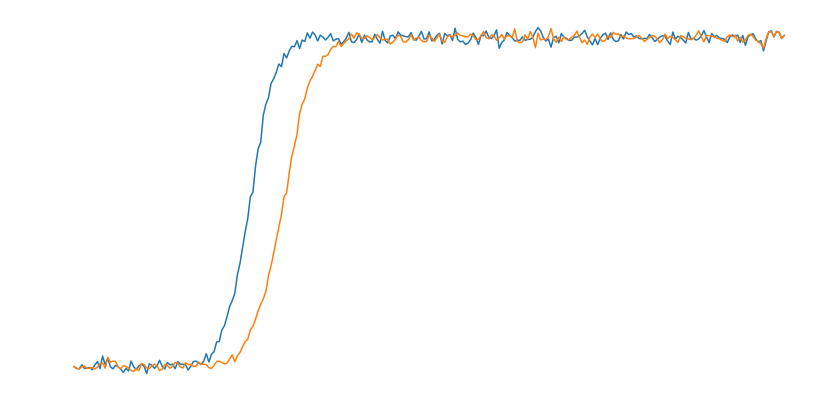

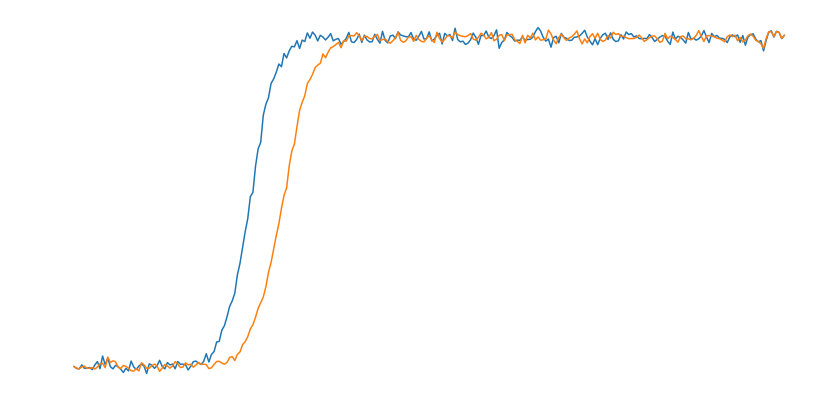

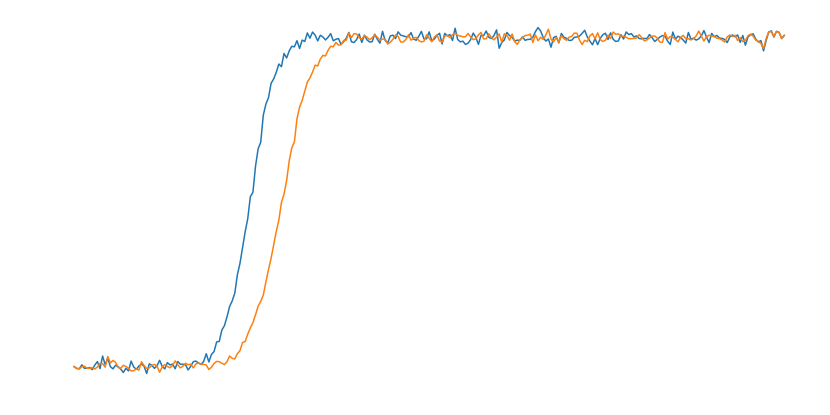

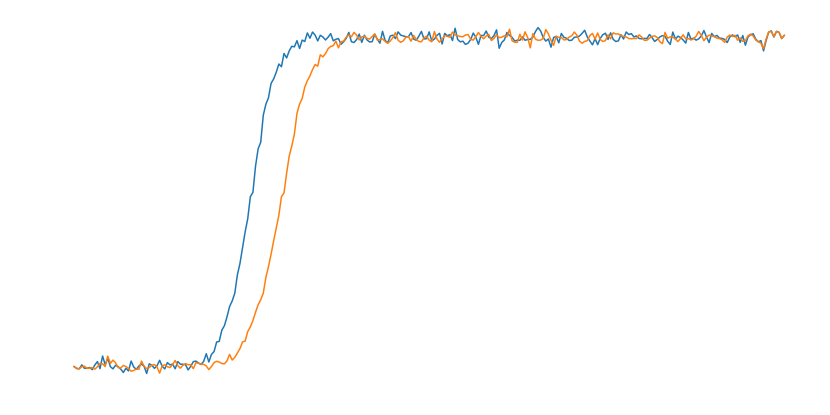

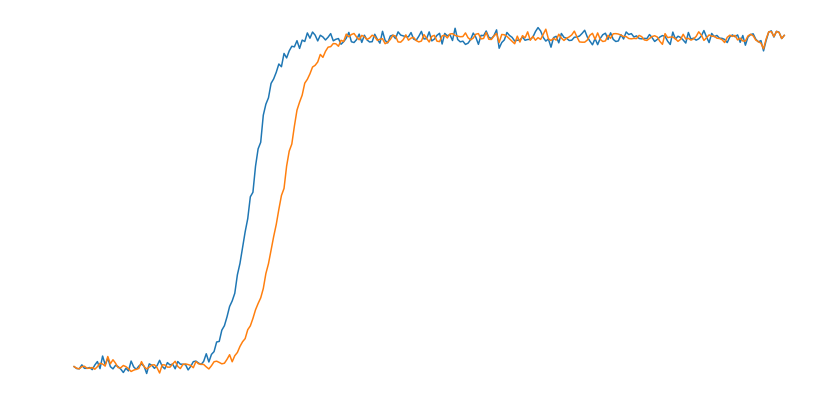

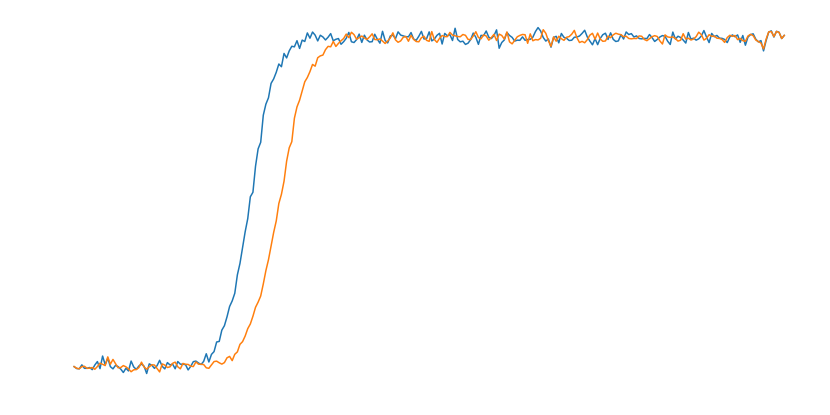

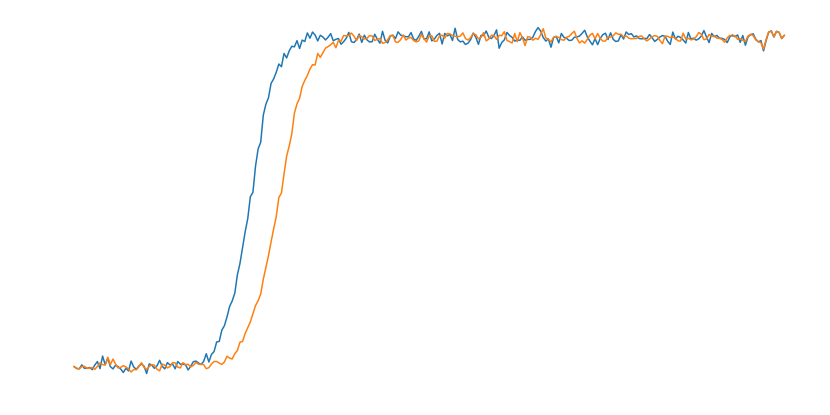

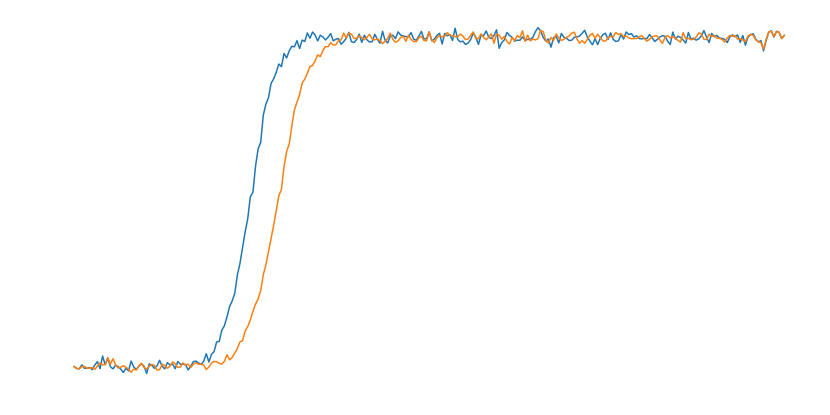

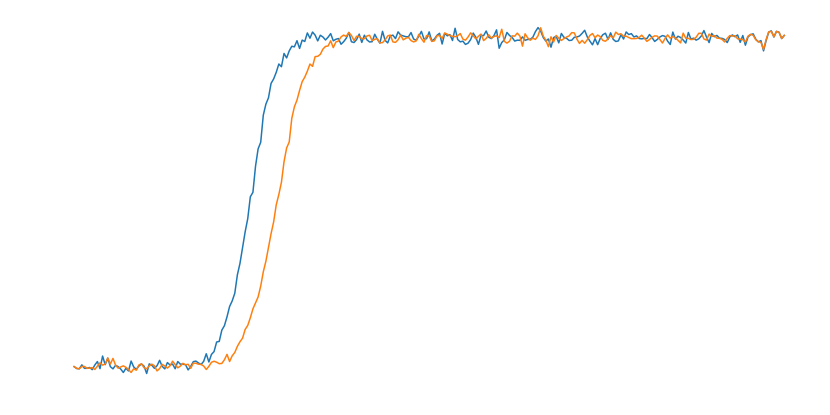

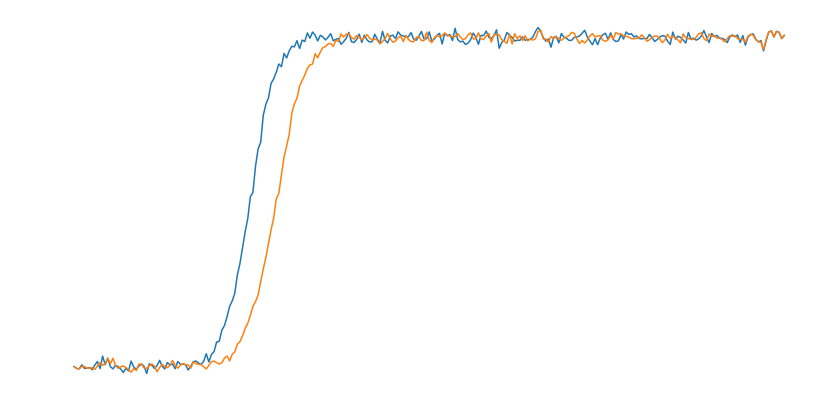

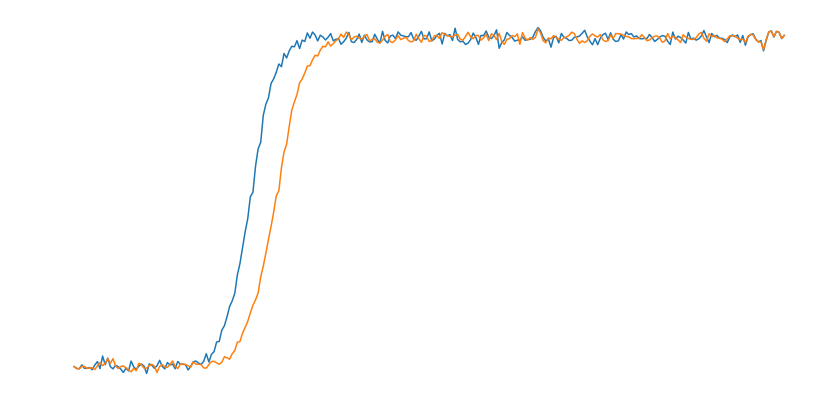

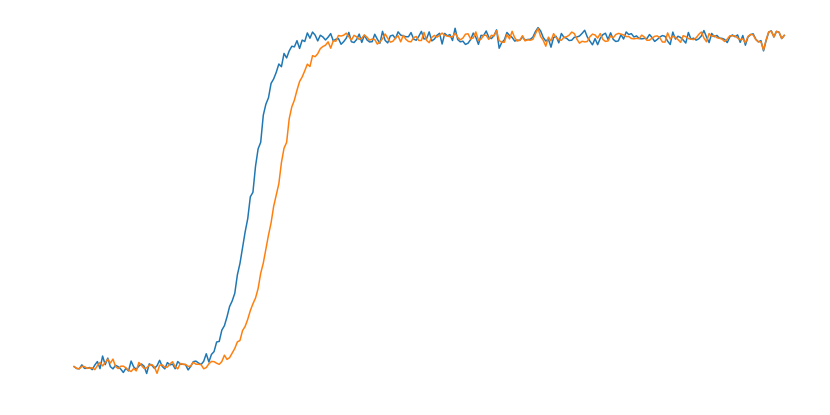

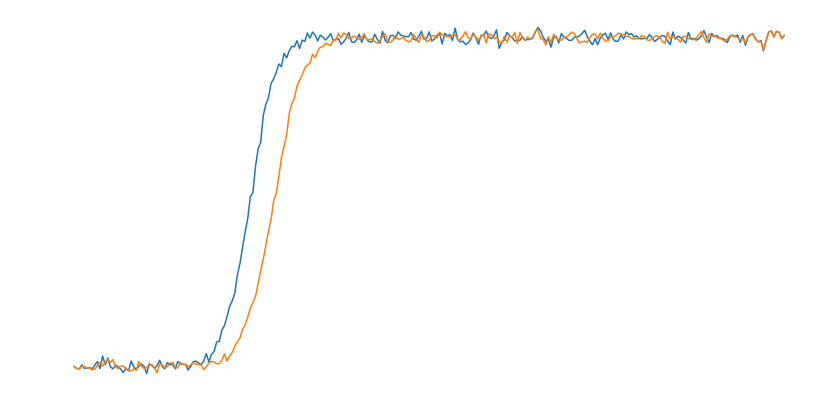

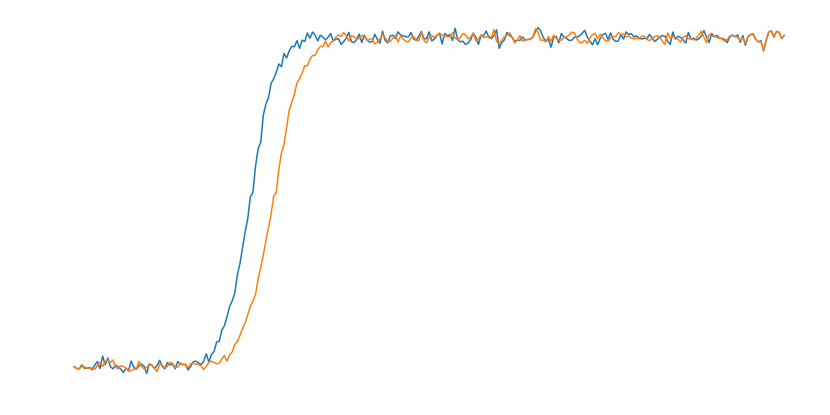

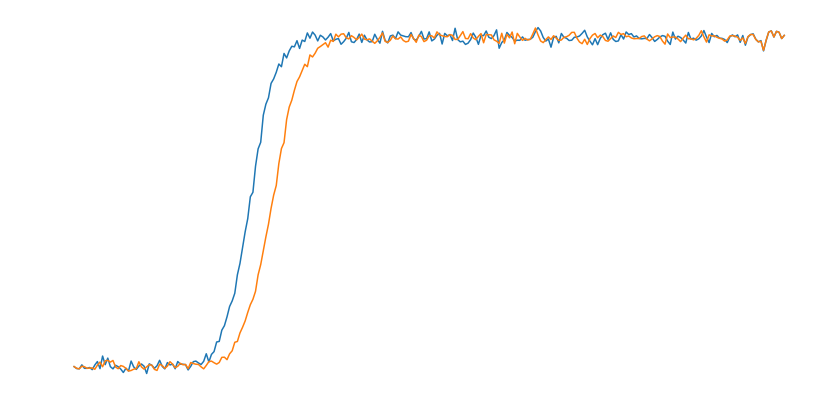

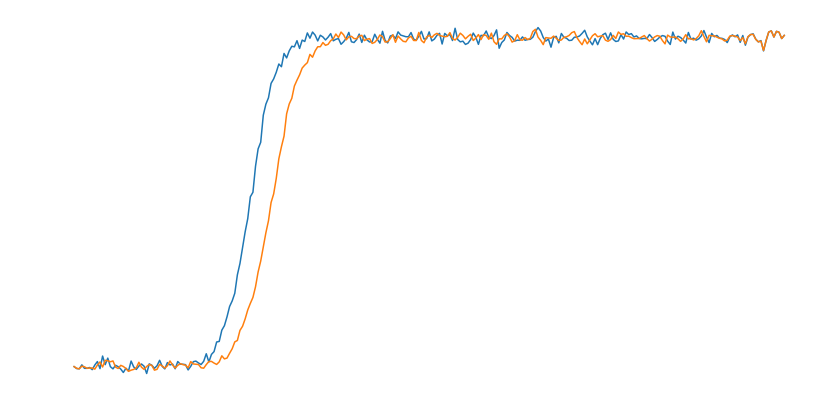

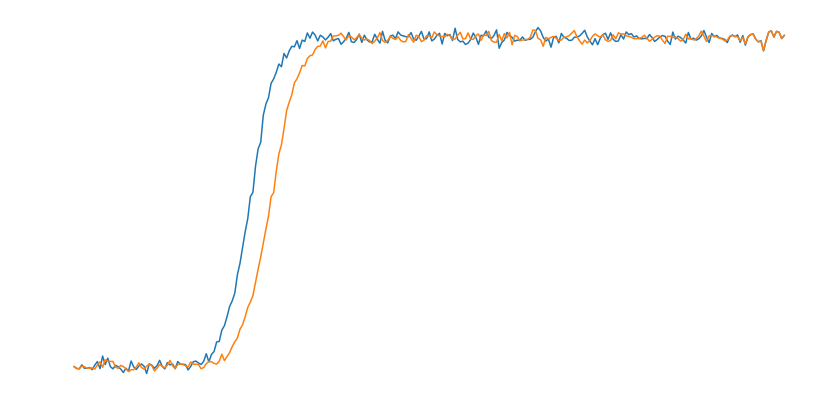

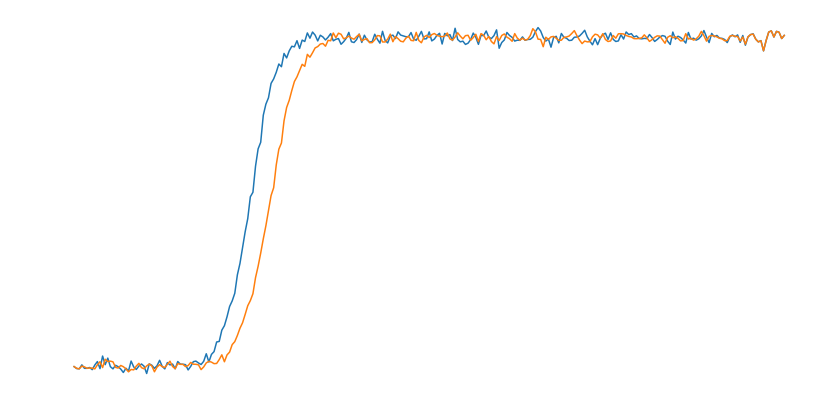

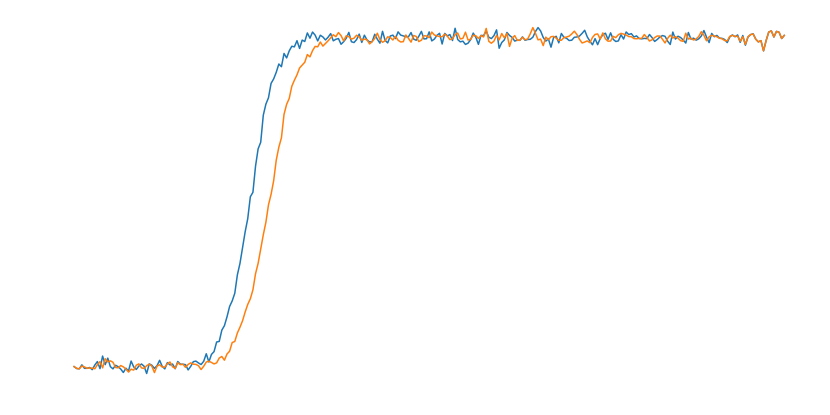

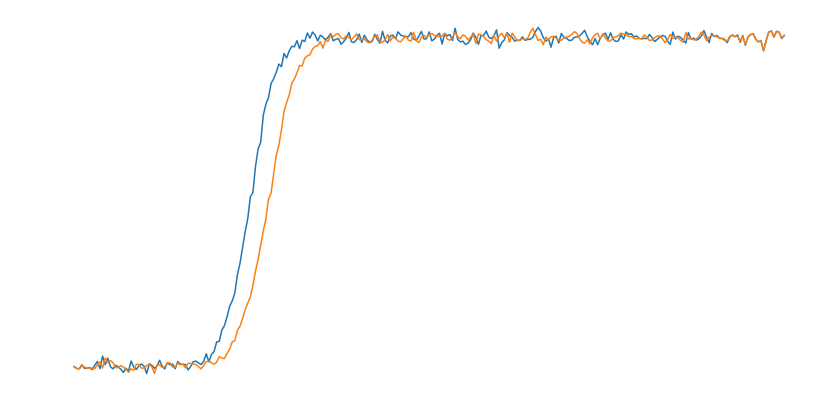

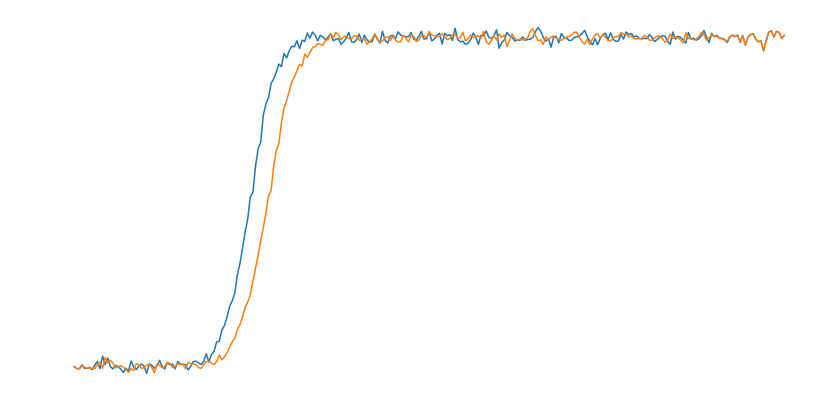

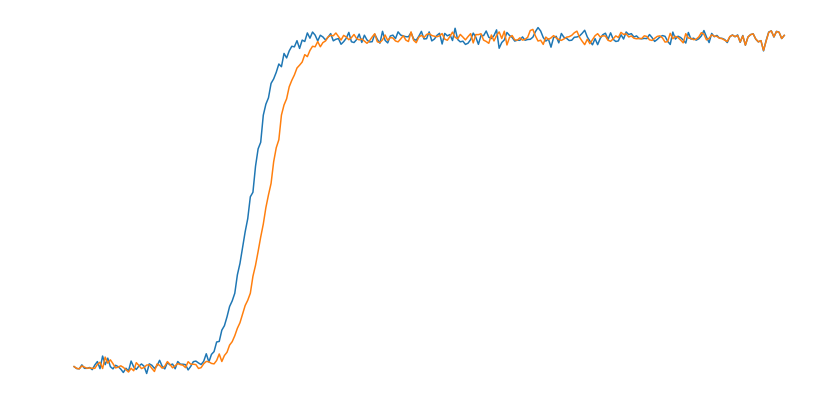

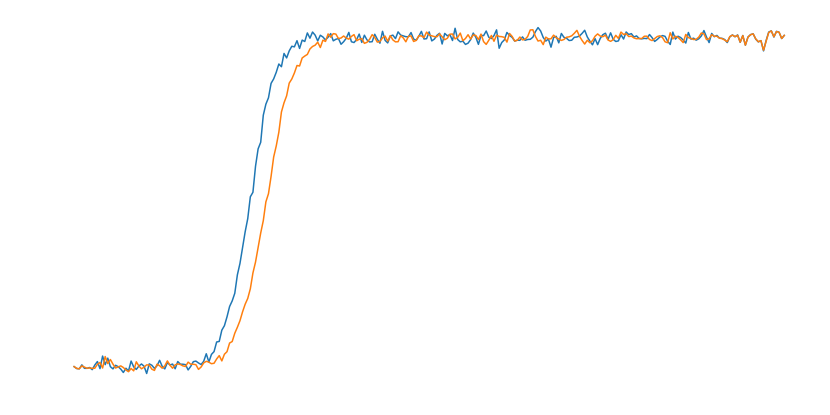

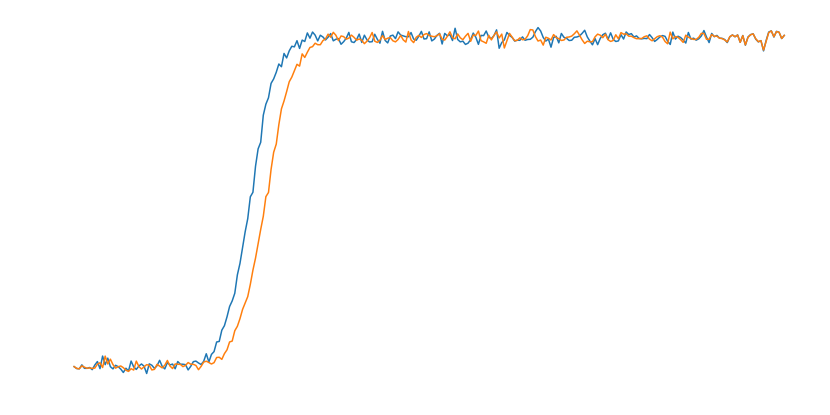

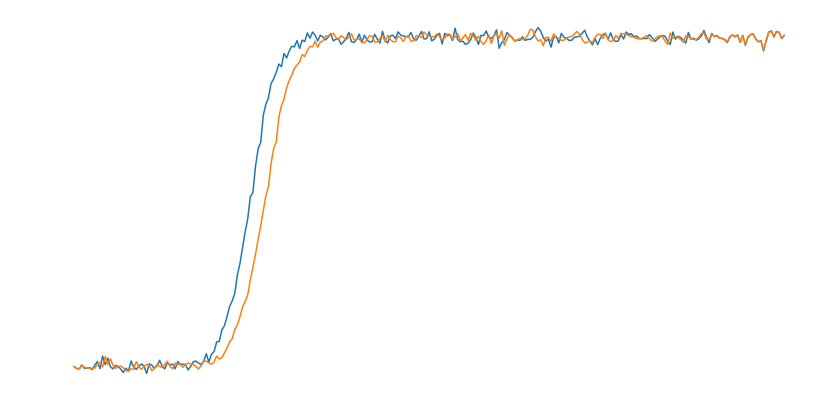

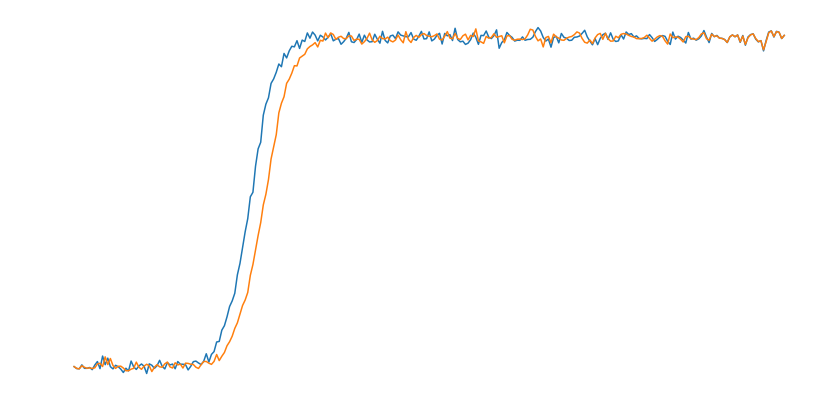

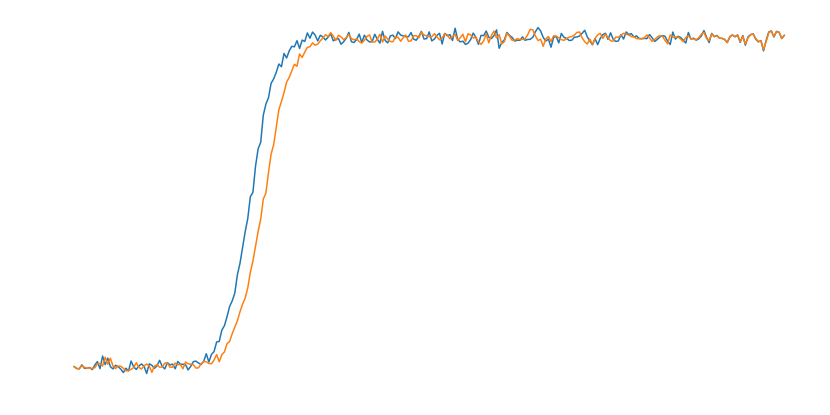

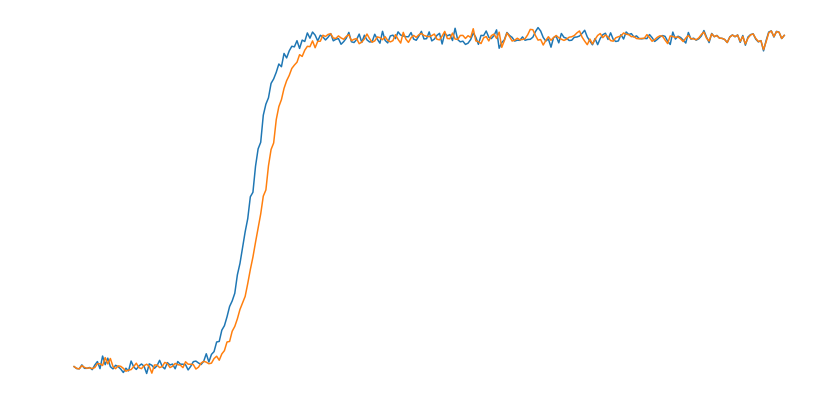

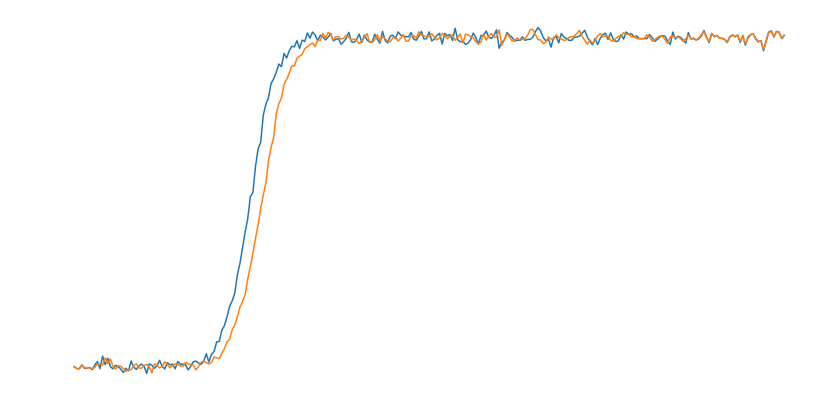

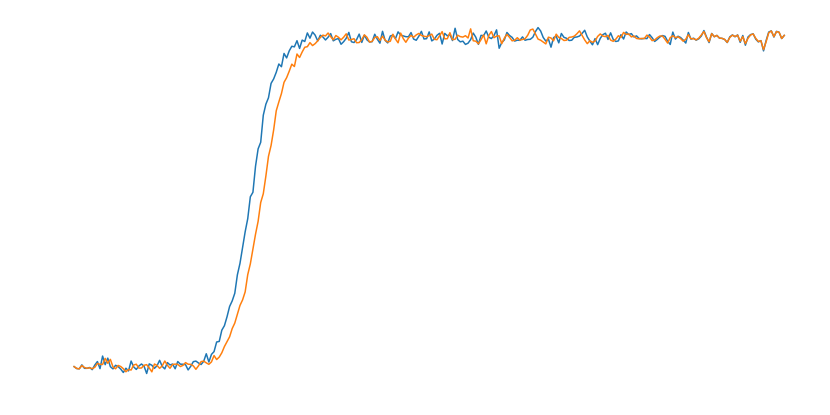

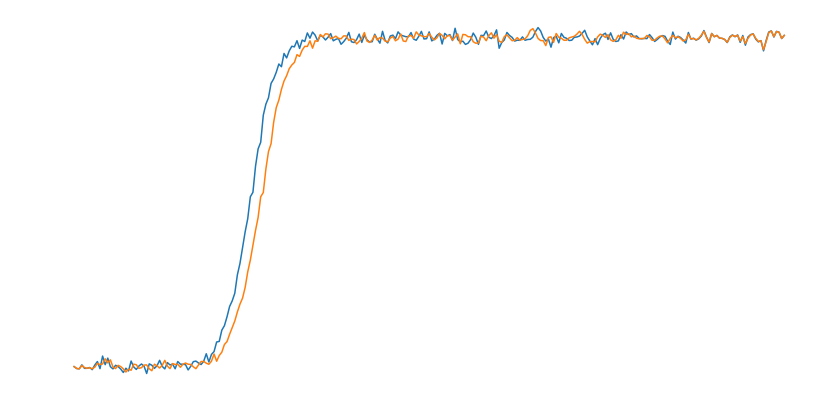

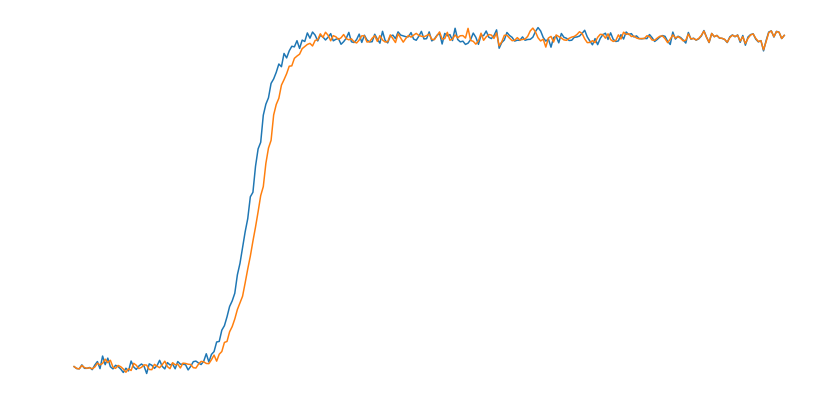

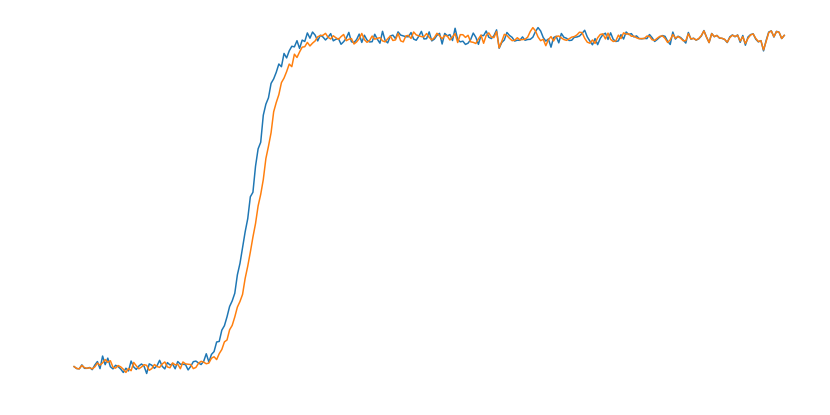

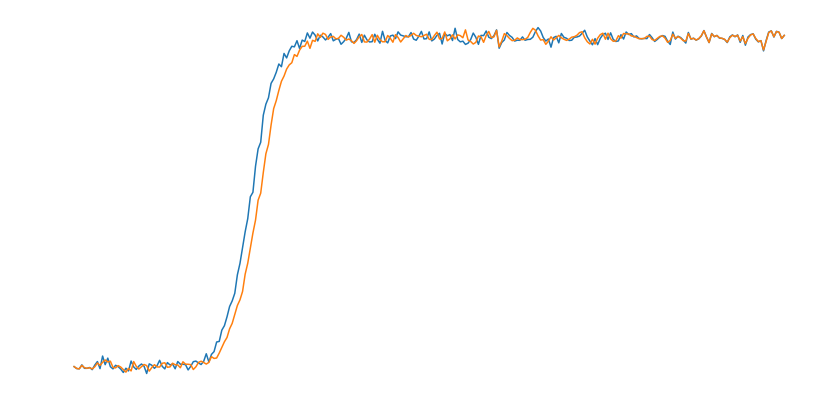

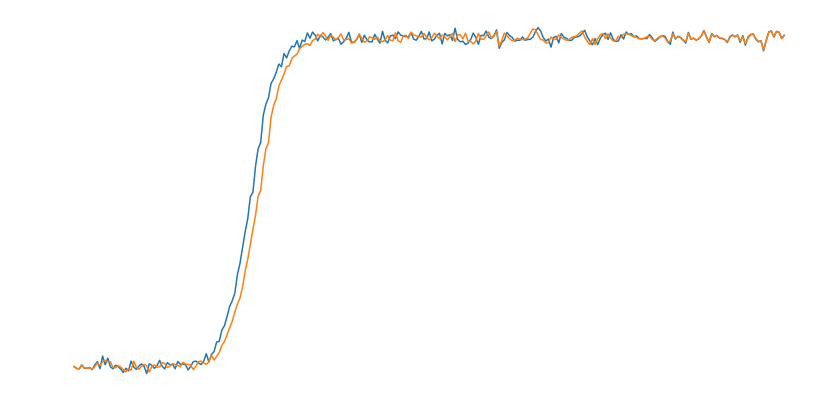

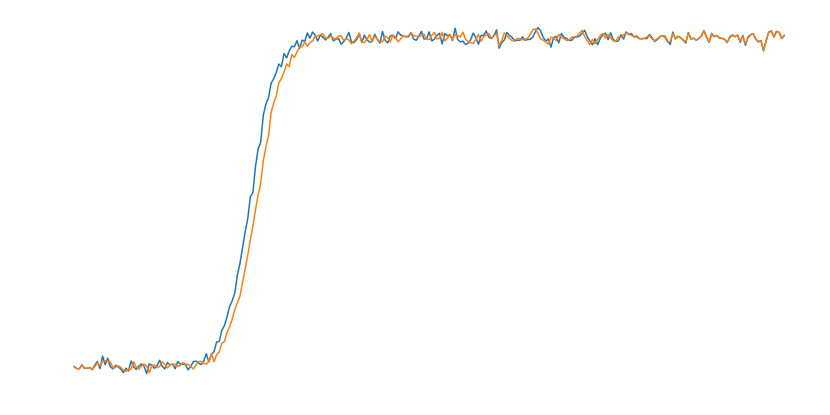

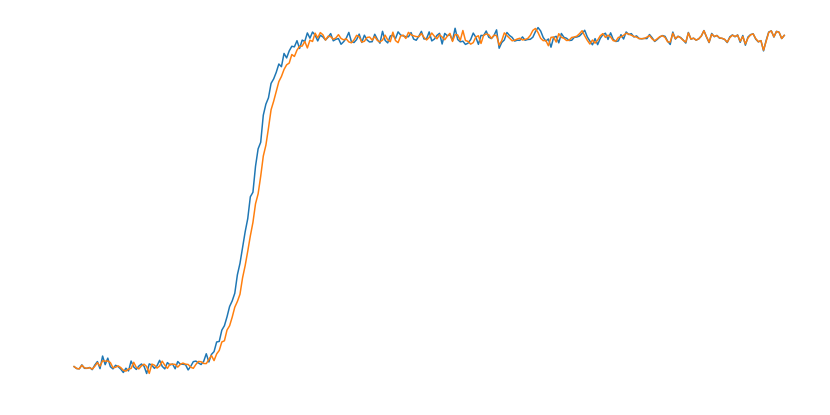

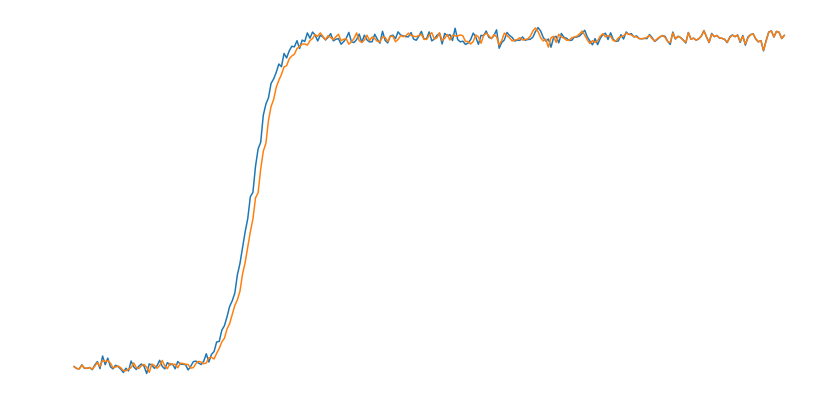

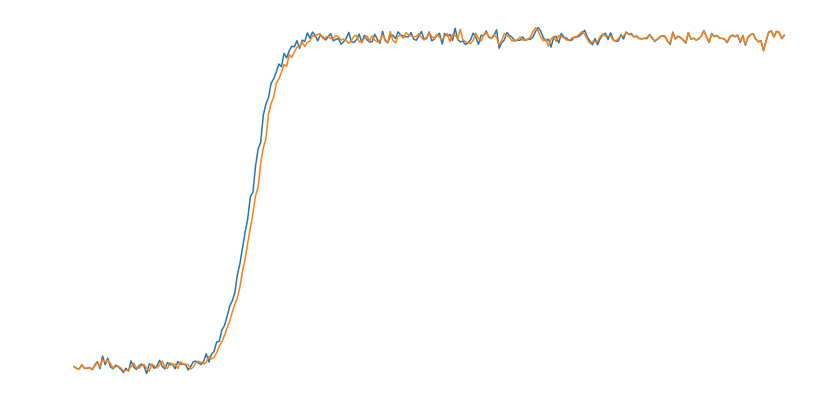

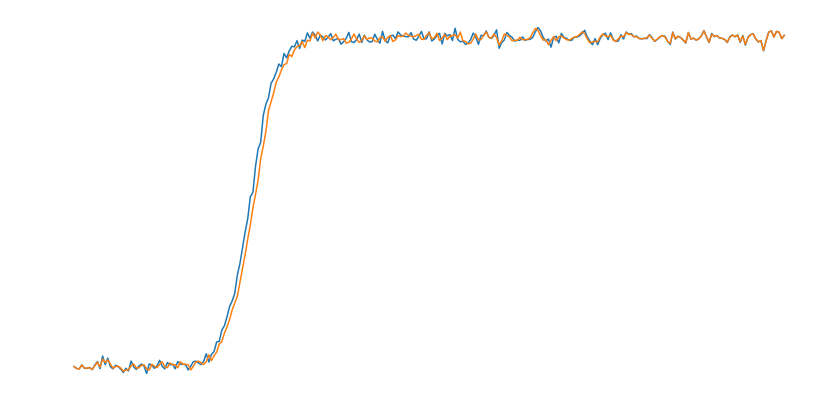

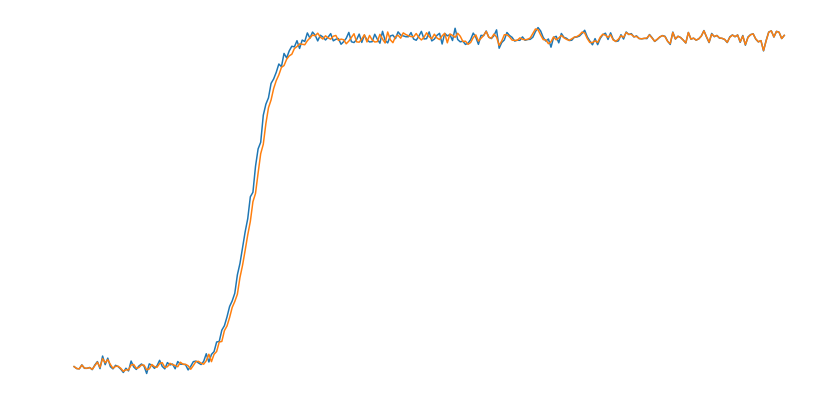

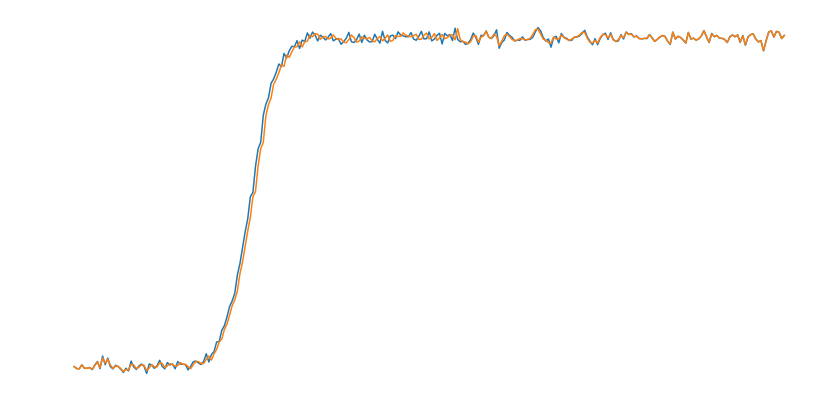

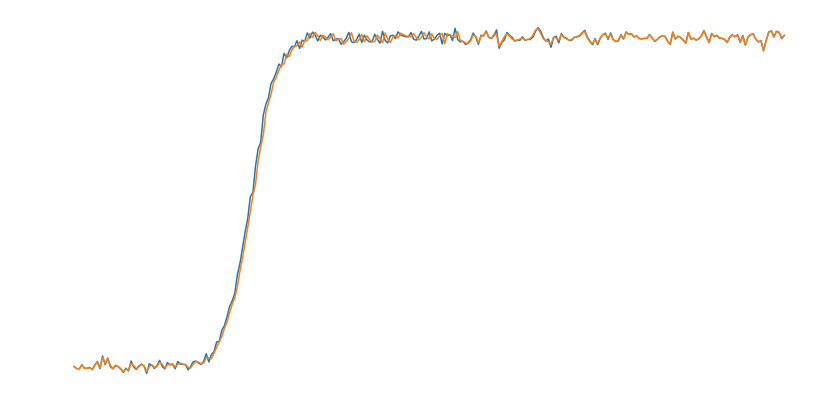

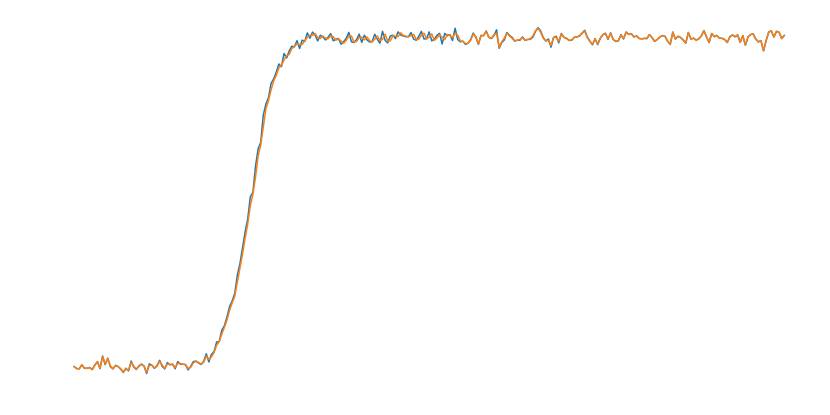

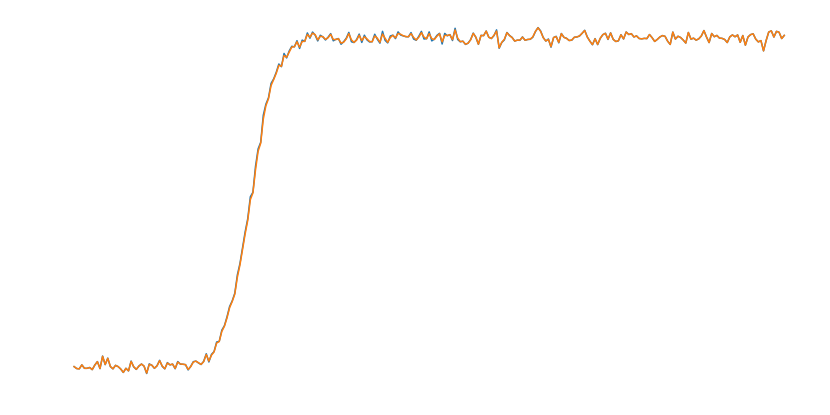

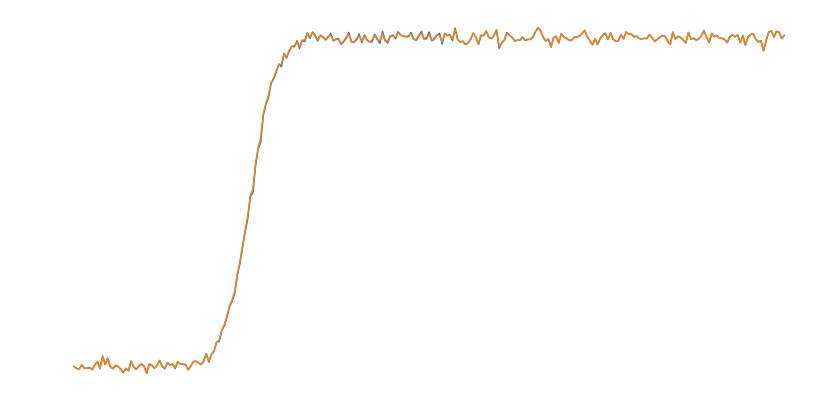

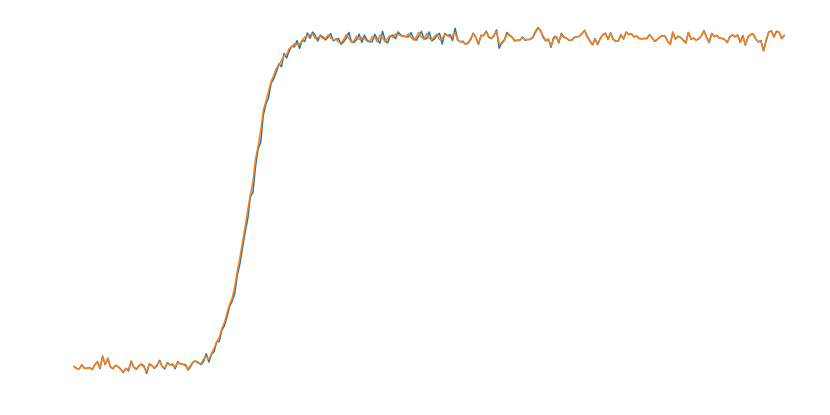

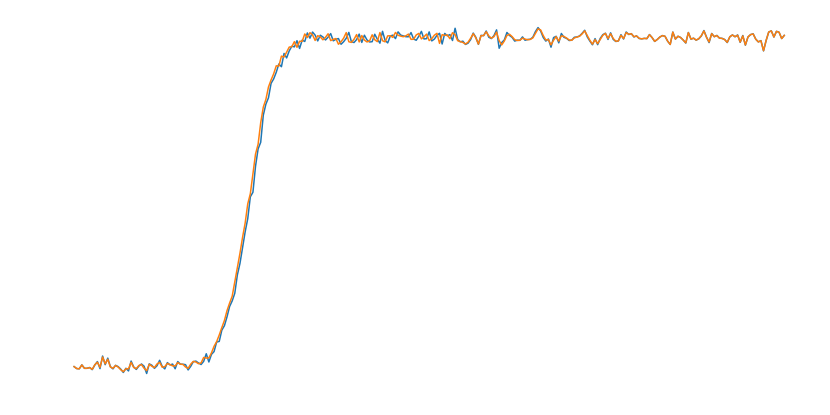

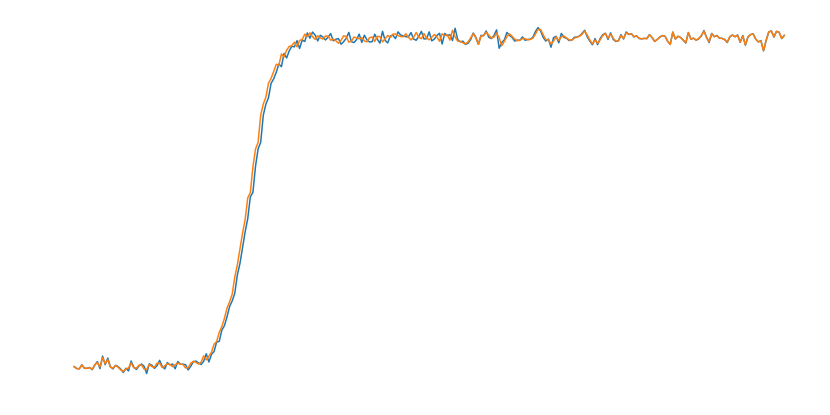

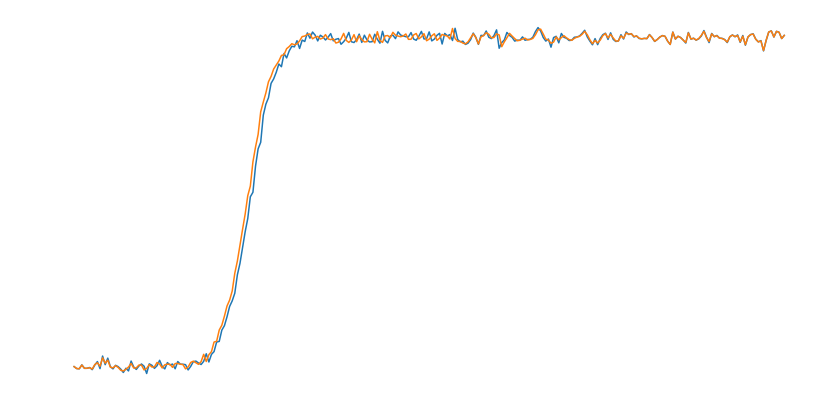

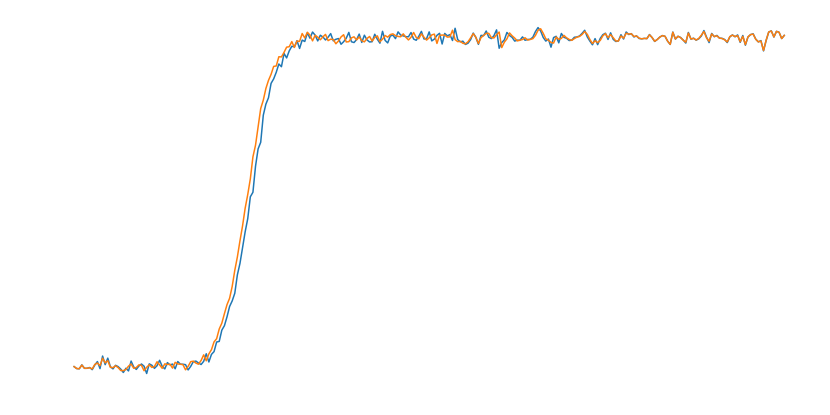

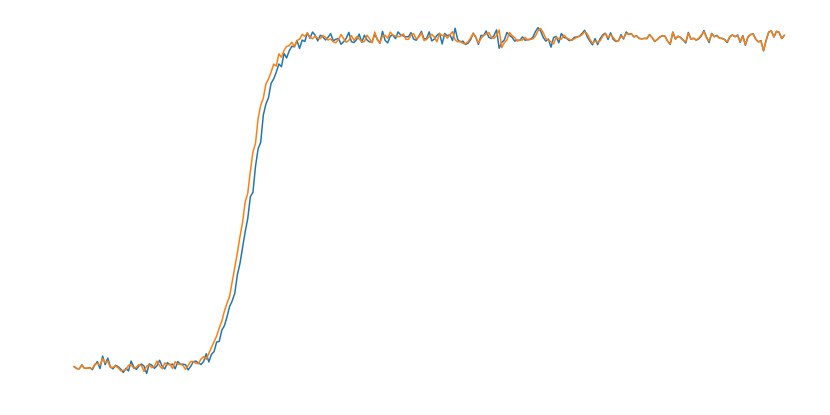

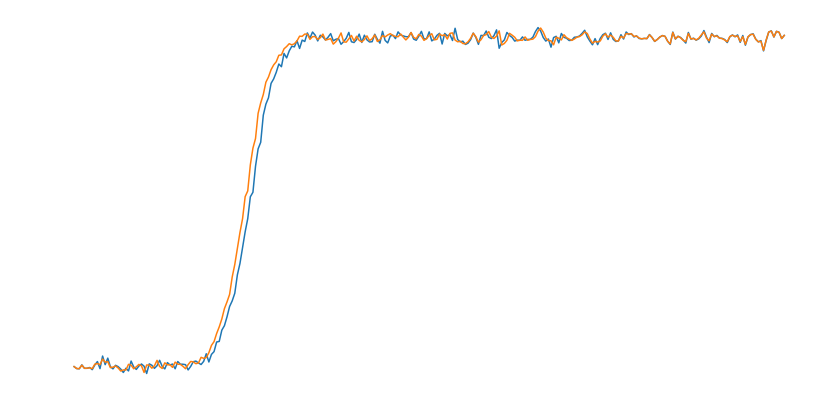

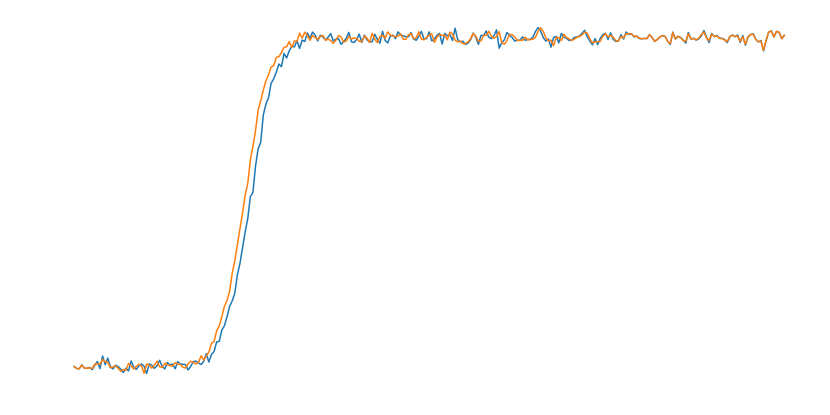

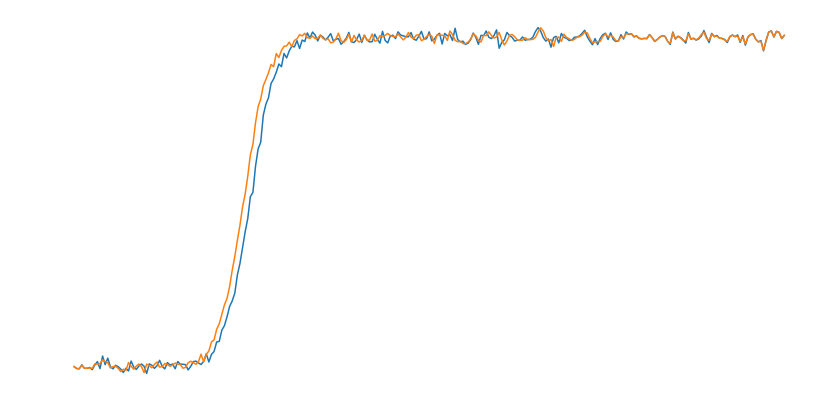

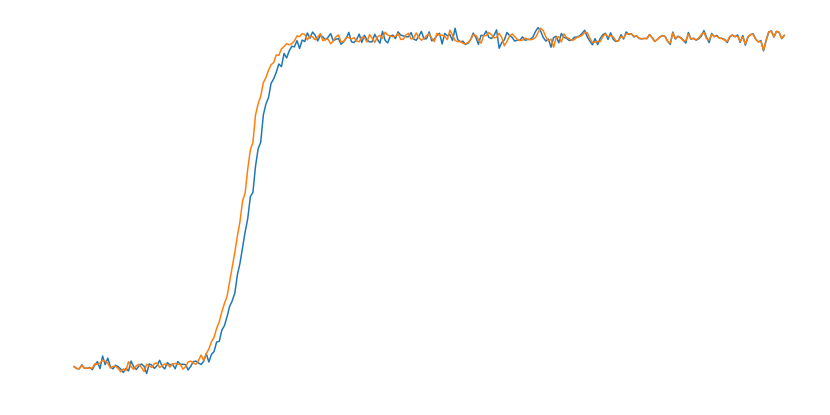

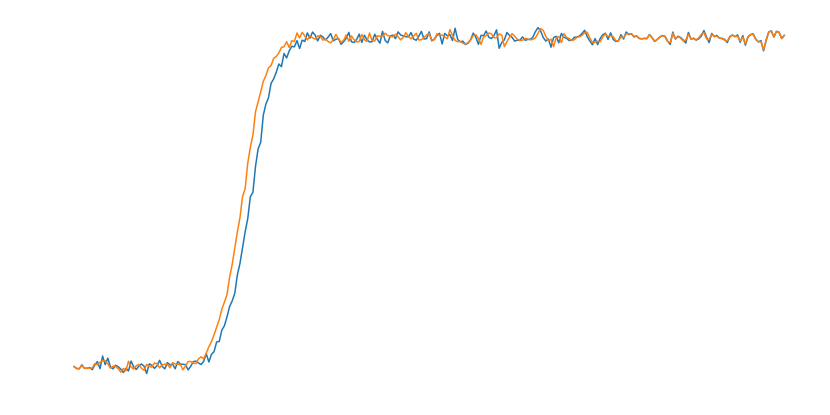

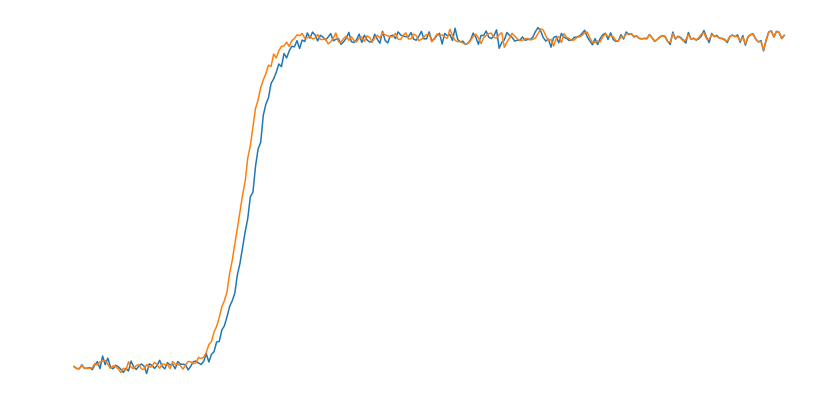

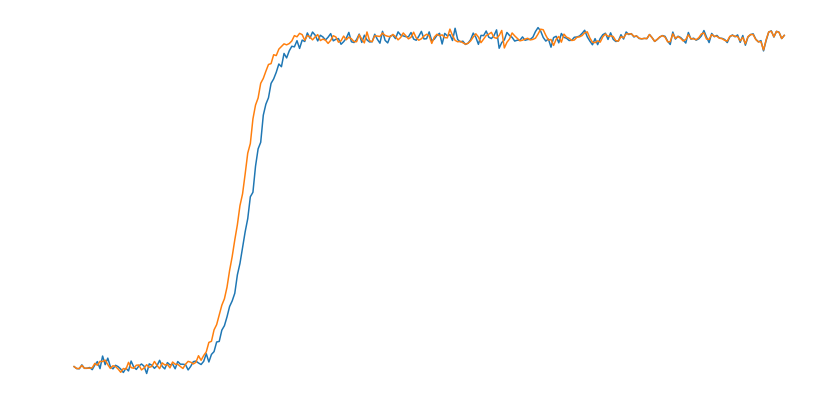

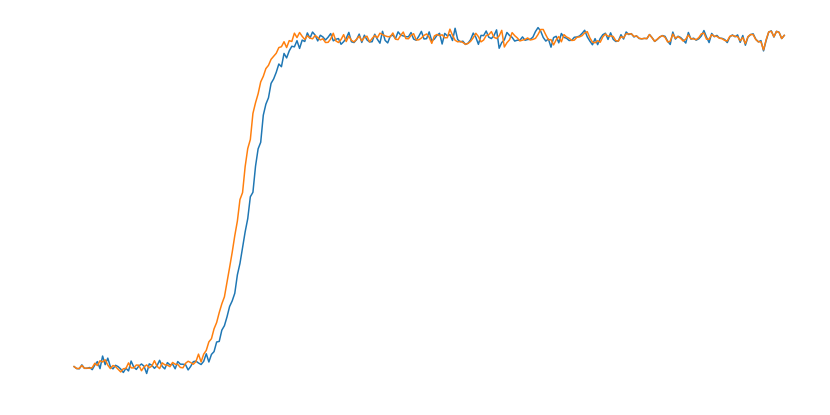

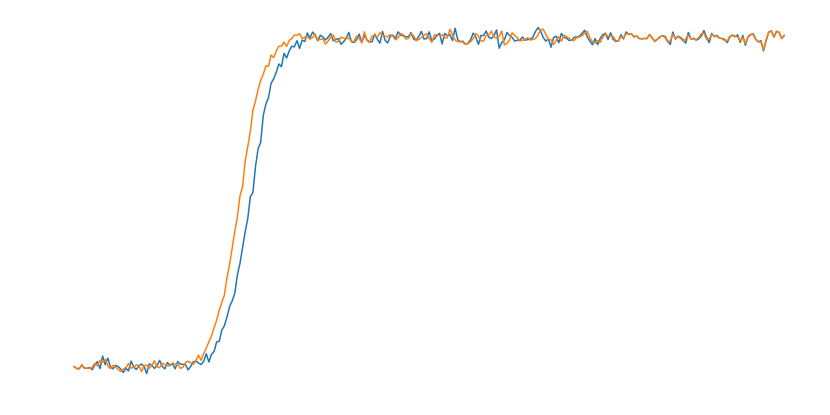

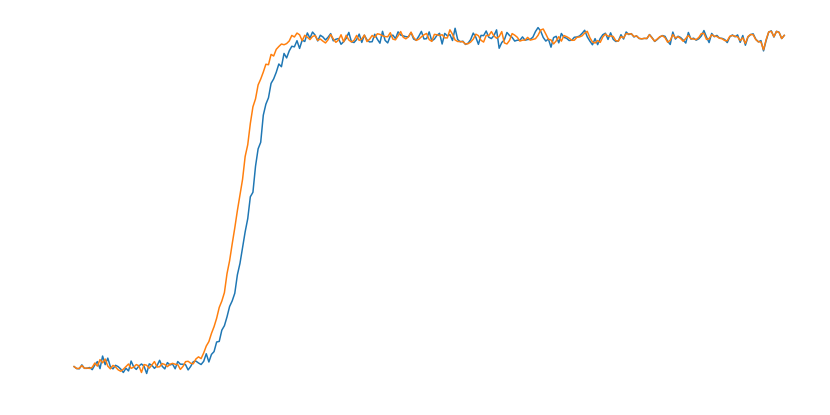

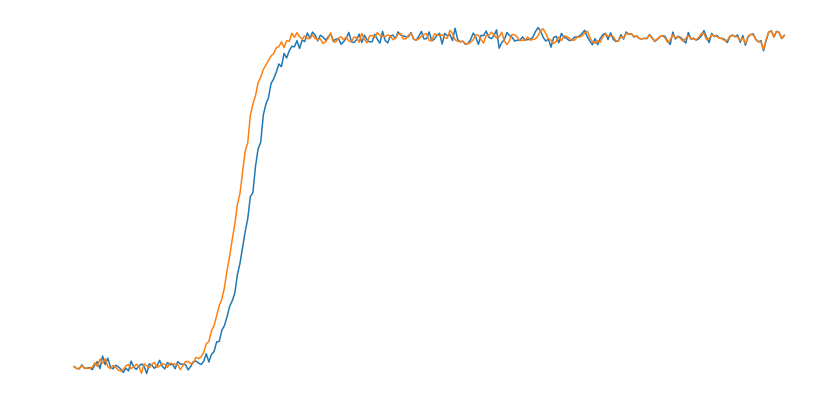

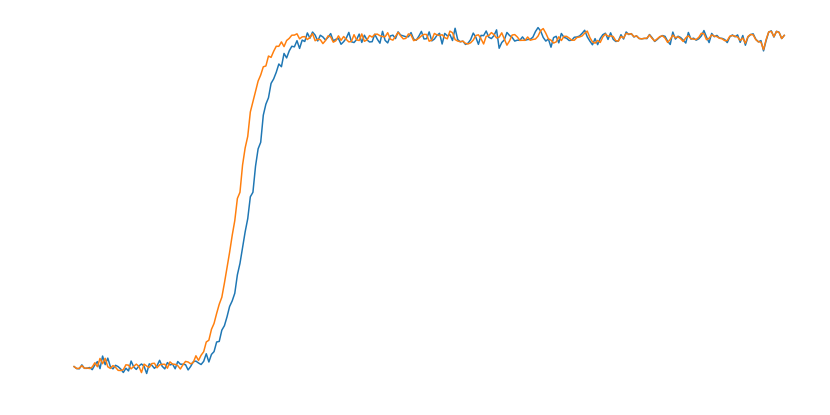

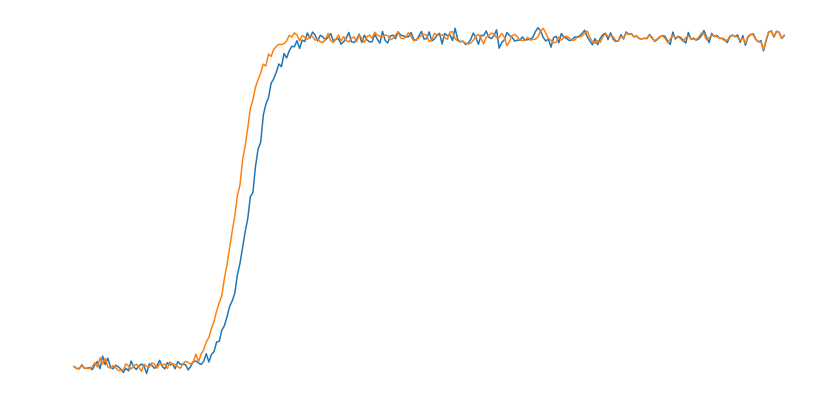

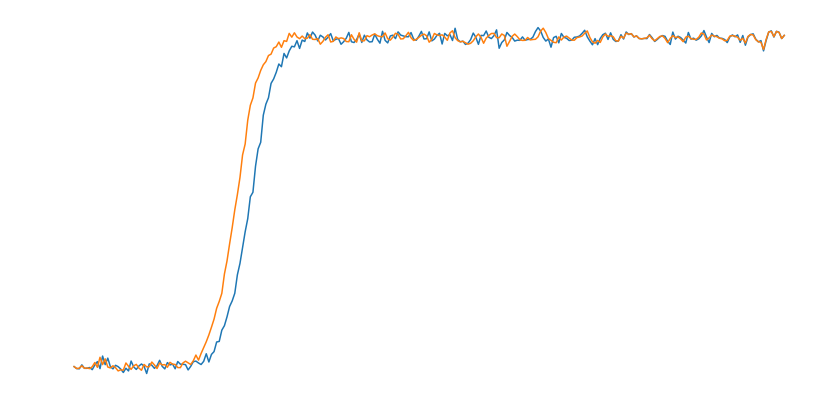

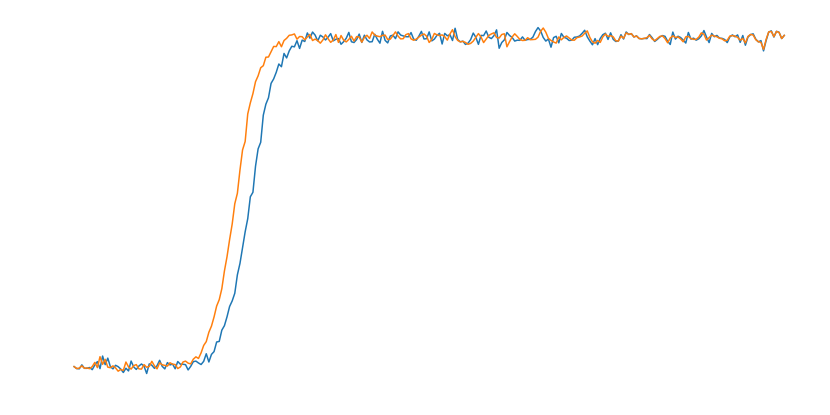

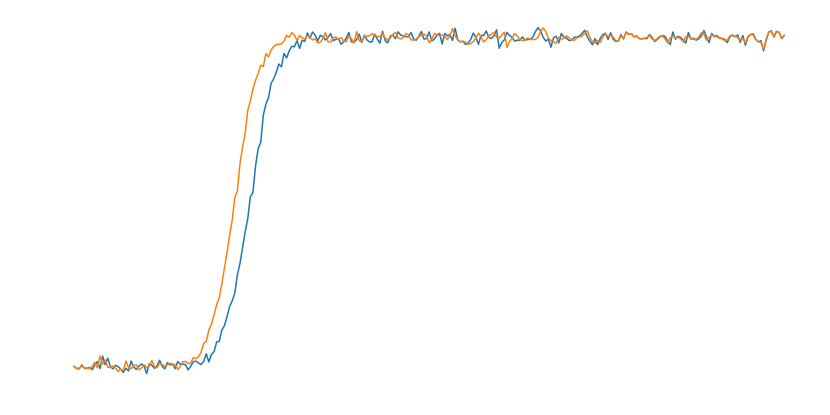

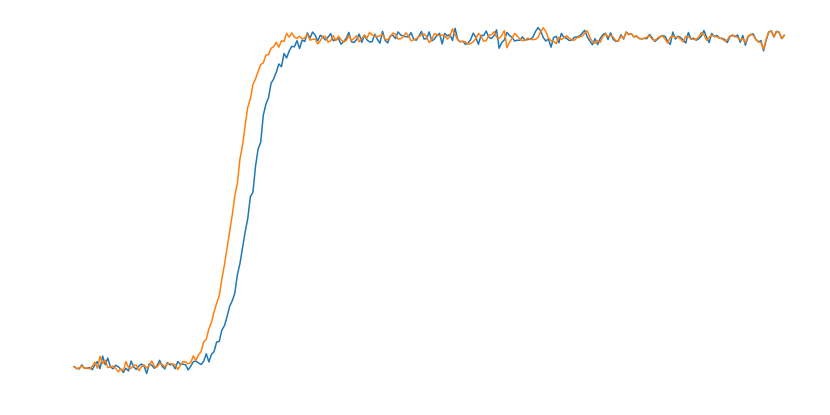

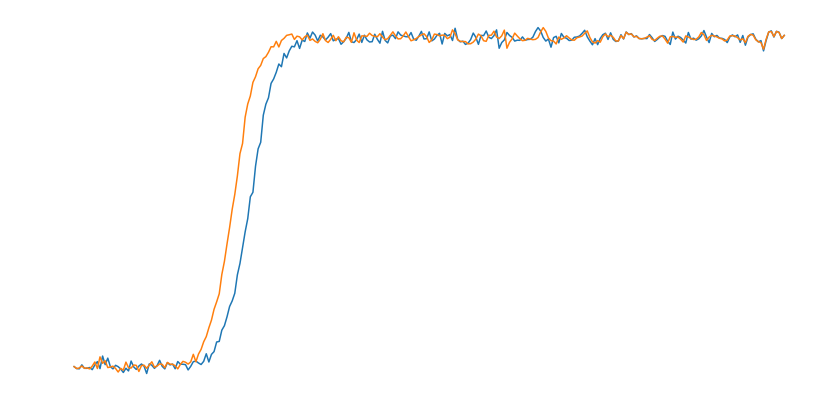

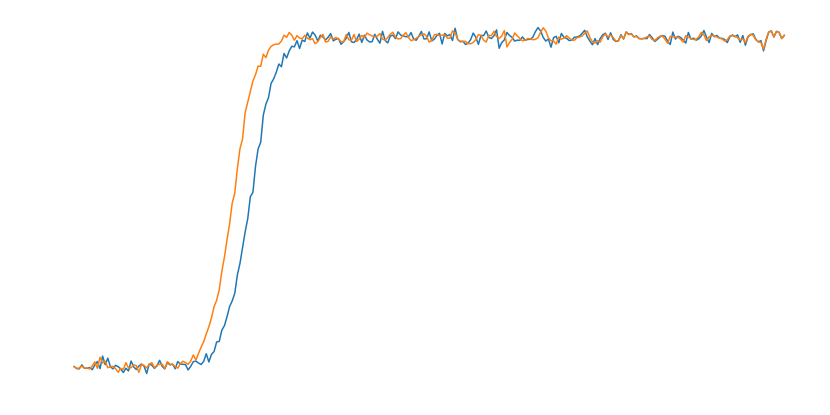

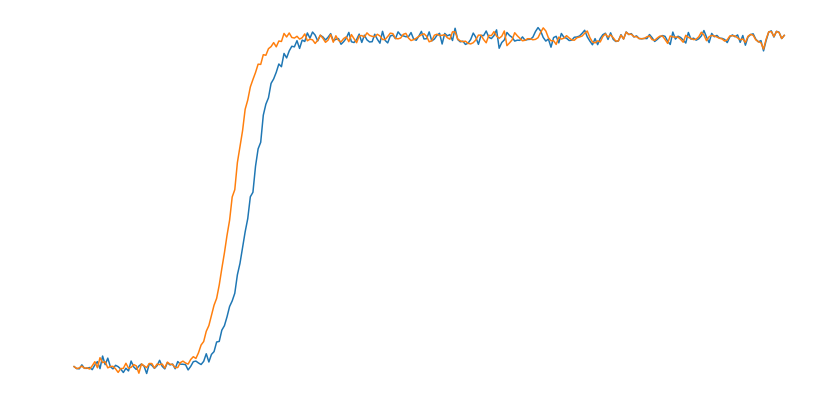

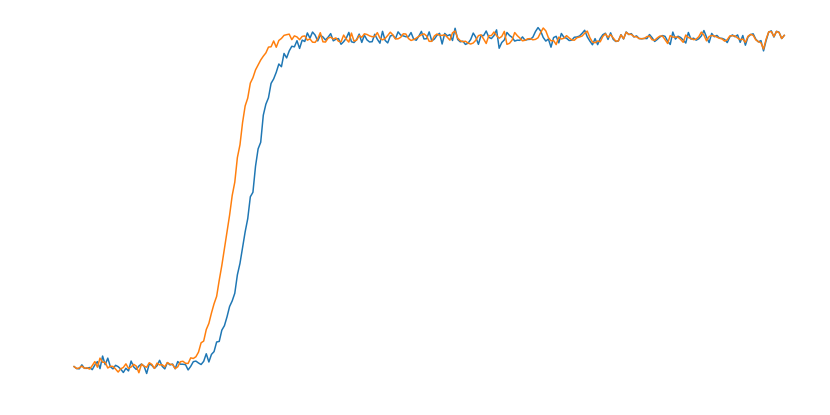

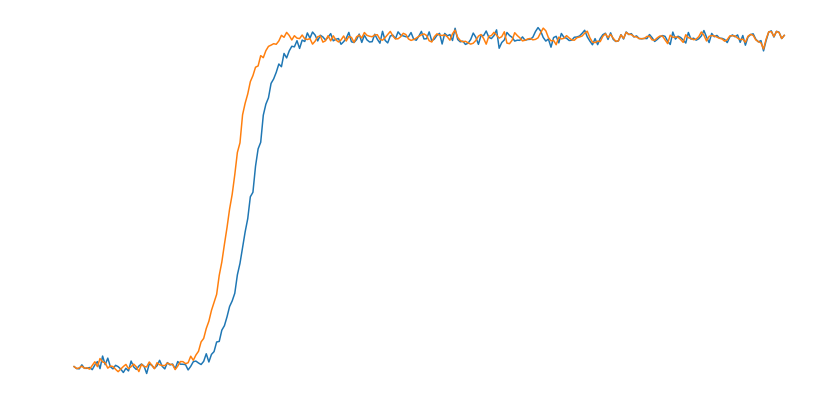

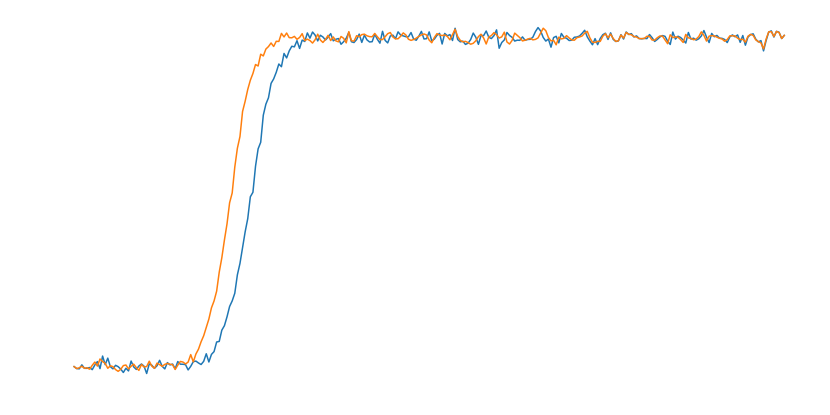

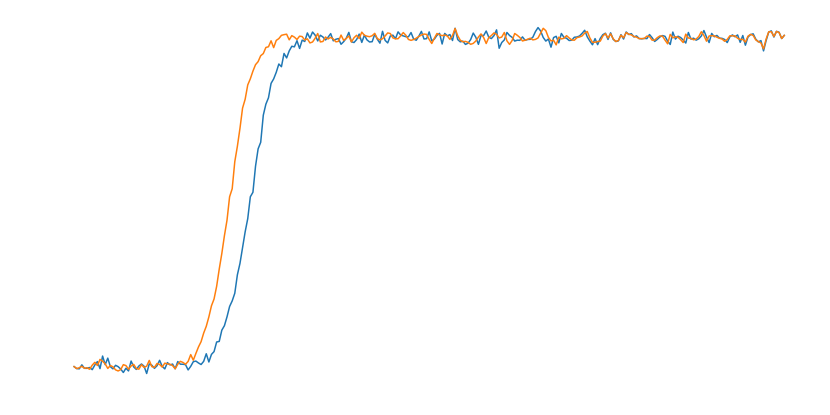

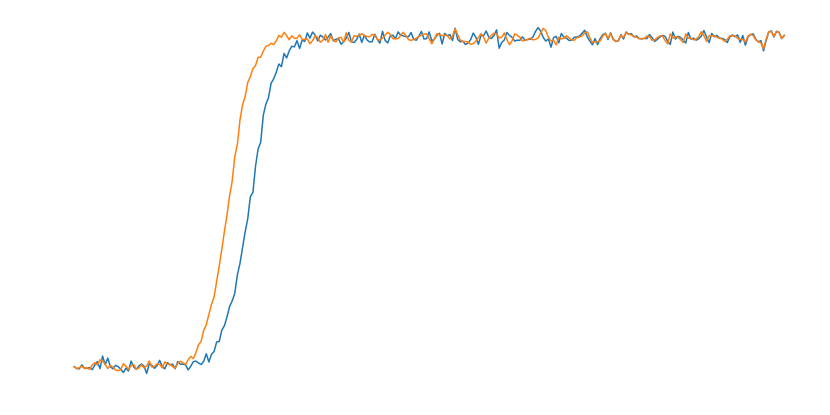

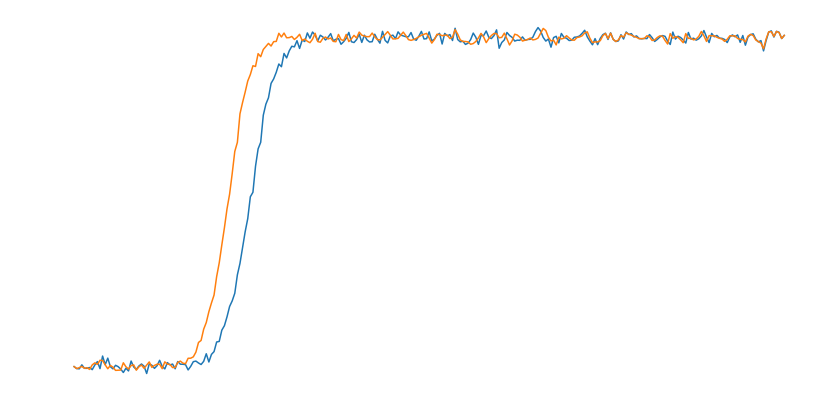

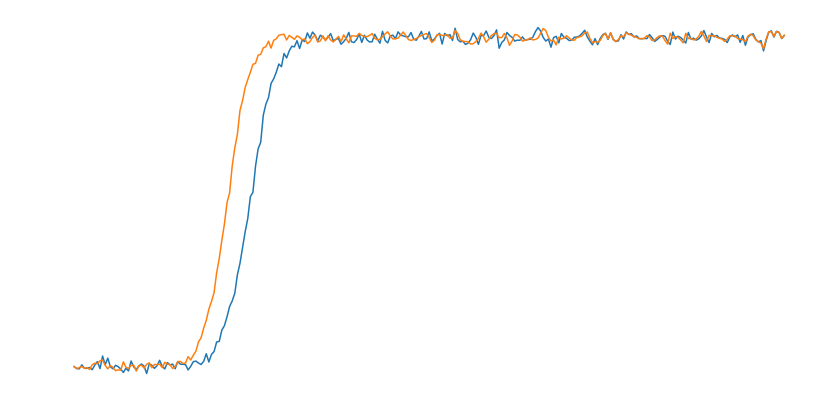

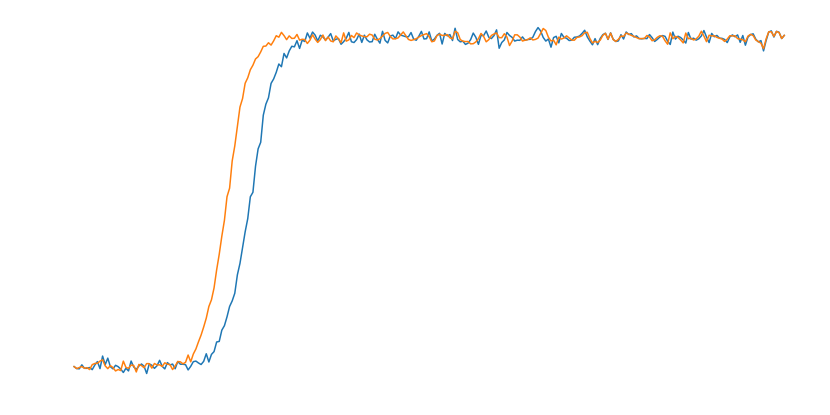

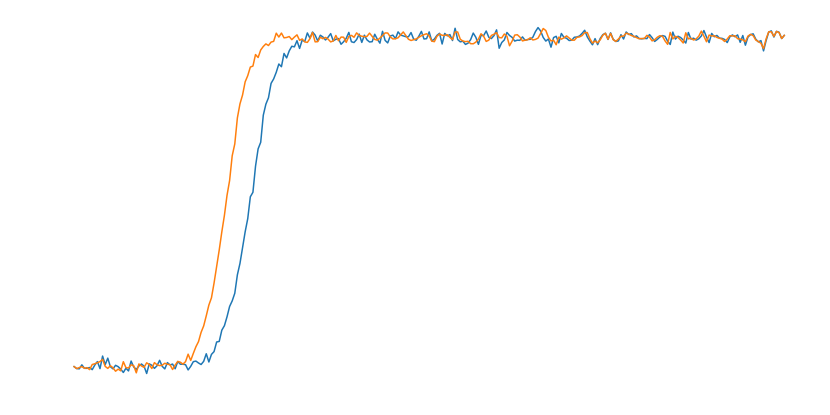

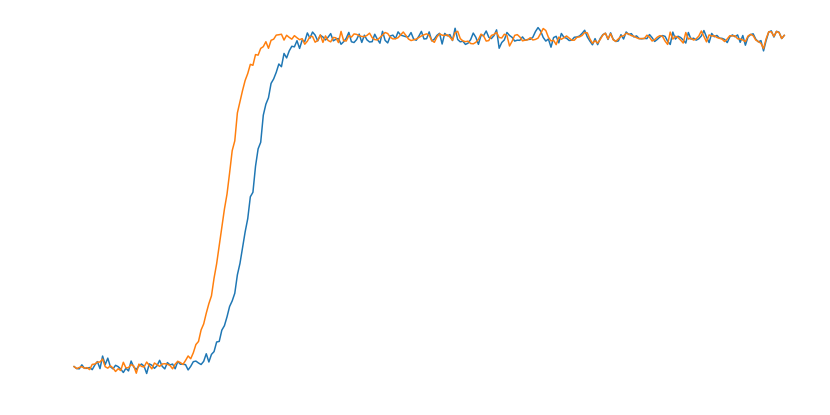

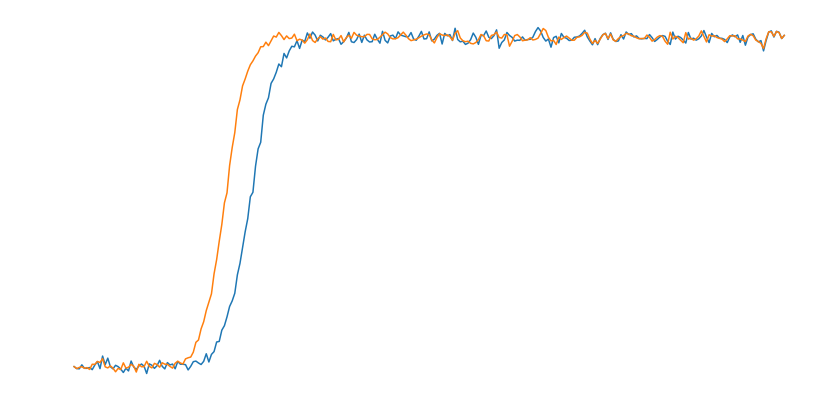

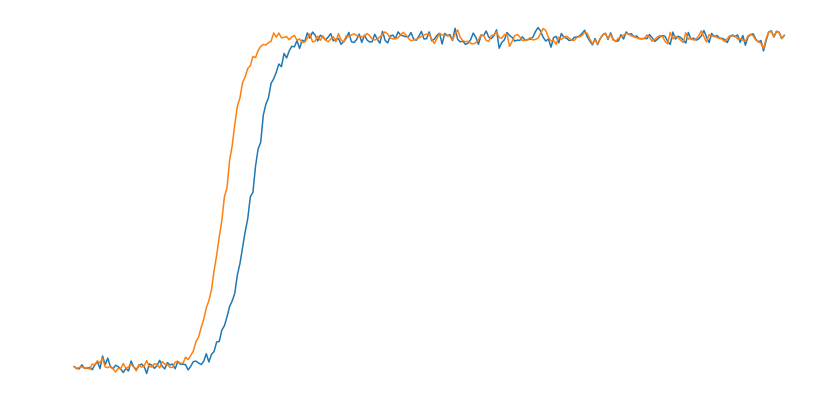

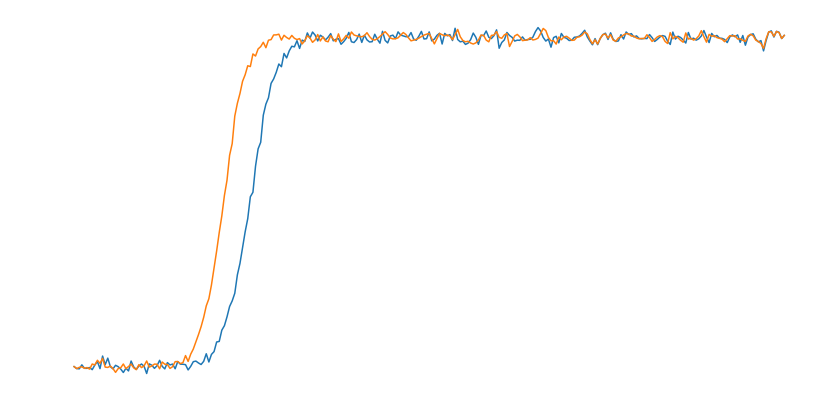

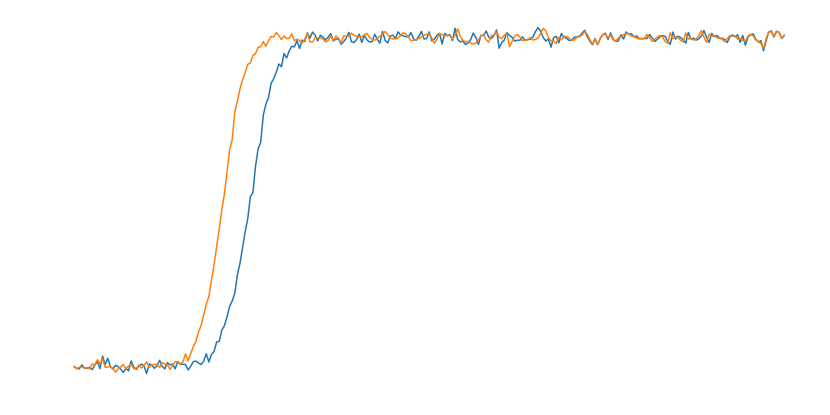

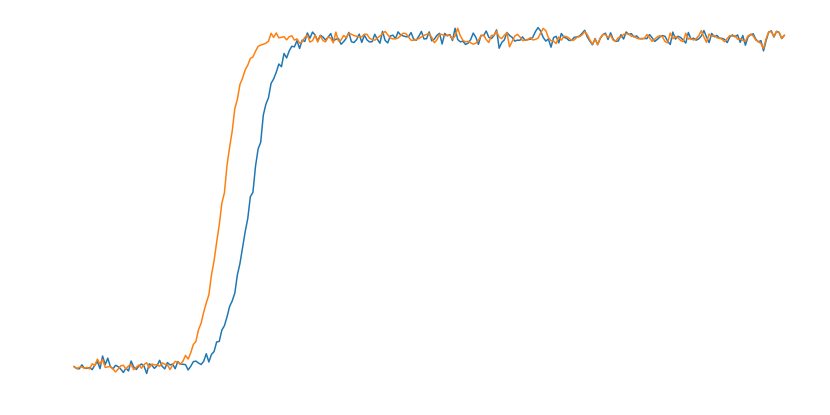

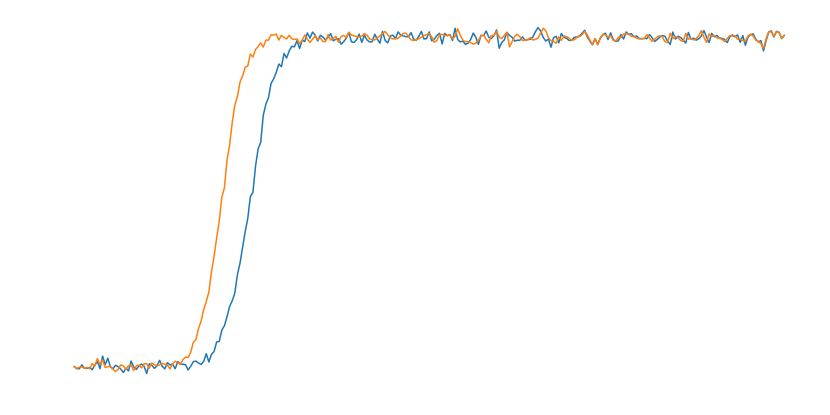

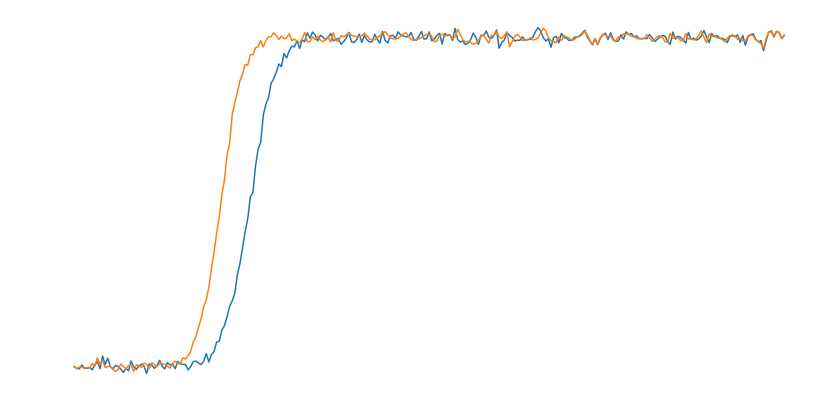

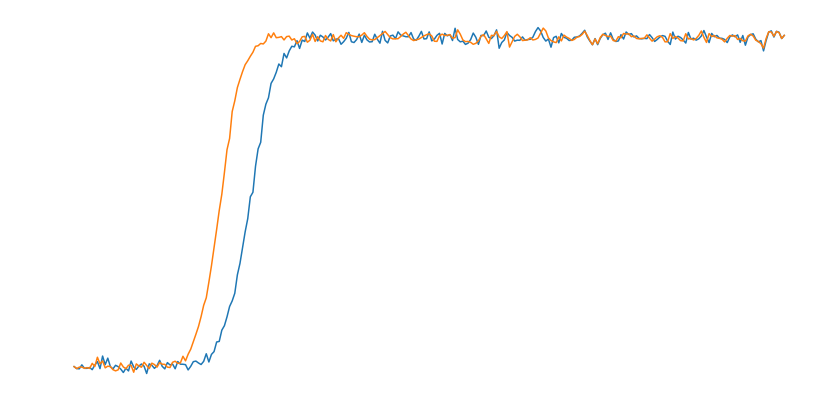

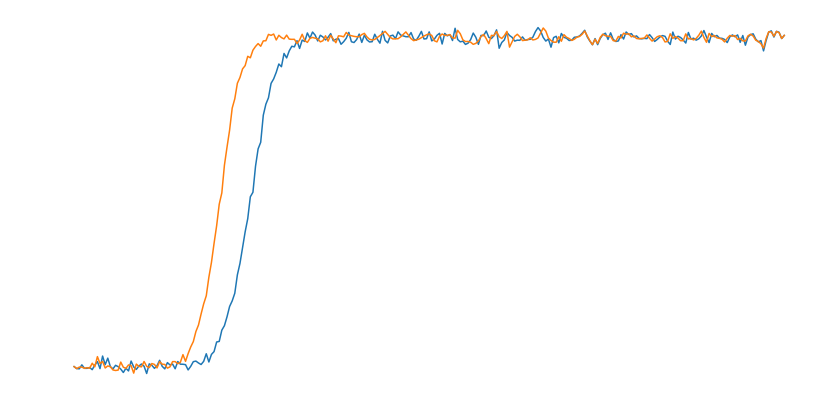

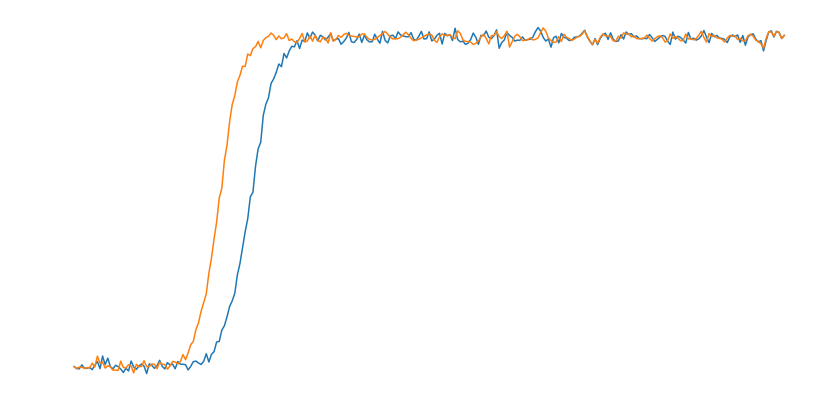

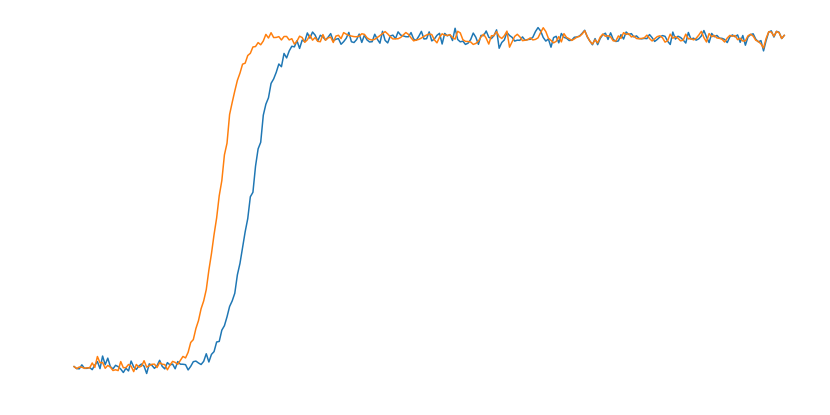

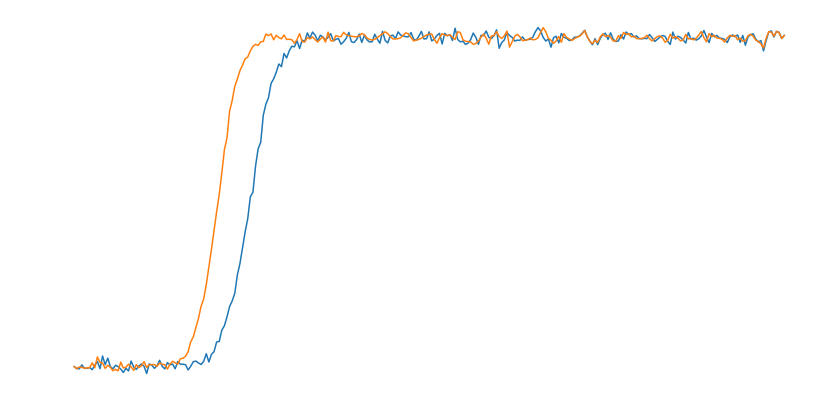

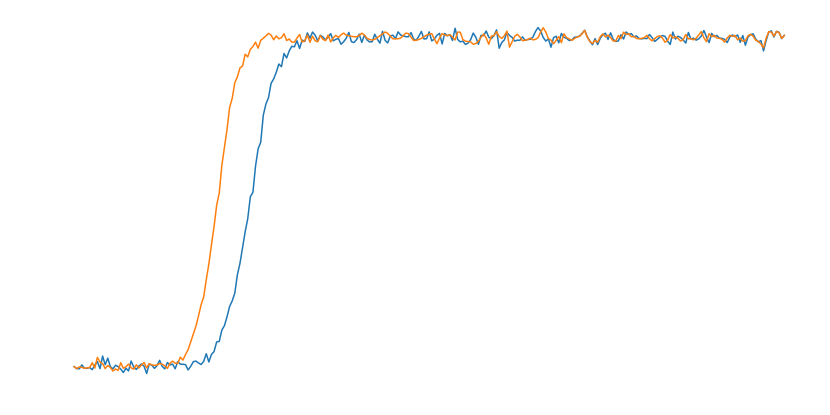

In [32]:
# slides_anim_imgs

imgs = []
for i in range(len(Theta)):
    plt.figure(figsize=(14, 7))
    plt.plot(x, data_point, x, data_point_trans[i])
    plt.axis('off')
    imgs.append(plt)

In [ ]:
img = None
for f in files:
    im=pl.imread(f)
    if img is None:
        img = pl.imshow(im)
    else:
        img.set_data(im)
    pl.pause(.1)
    pl.draw()

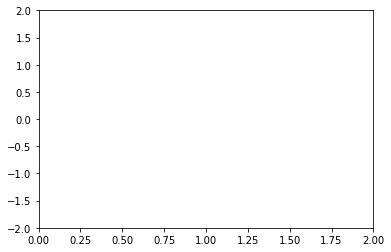

In [27]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

In [28]:
def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

In [29]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=20, blit=True)

In [30]:
HTML(anim.to_html5_video())

In [120]:
plt.rcParams['animation.ffmpeg_path'] = u'/home/username/anaconda/envs/env_name/bin/ffmpeg' 
print(animation.writers.list())

['html']


## Random projection plot

In [38]:
# Fetch eigenvalue and eigenvector as explained variance and pca component
pca_i = 1
lambda_1 = pca.explained_variance_ratio_[pca_i-1]
v_1 = pca.components_[pca_i-1]

print(lambda_1)
print(v_1)

0.797336326443
[-0.09415823  0.44672693  0.84694451 -0.1374784  -0.22951284 -0.00686091
  0.01360702  0.01007364  0.01824123 -0.03554839 -0.02734393]


In [39]:
# Sample N points from Gaussian to be projected along principal component
N = 1000
mu, sigma = 0, 1
w = np.random.normal(mu, sigma, size=(N, d, 2))

# Project into 2 dimensions
w_proj = np.matmul(v_1, w)

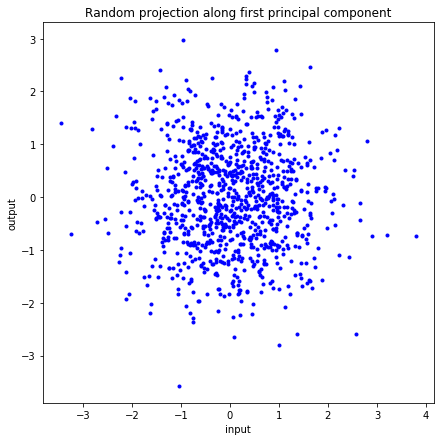

In [40]:
# Plot random projections
plt.figure(figsize=(7, 7))
plt.plot(w_proj[:,0], w_proj[:,1], 'b.')
plt.xlabel('input')
plt.ylabel('output')
plt.title('Random projection along first principal component')
plt.show()

#### Along all principal components

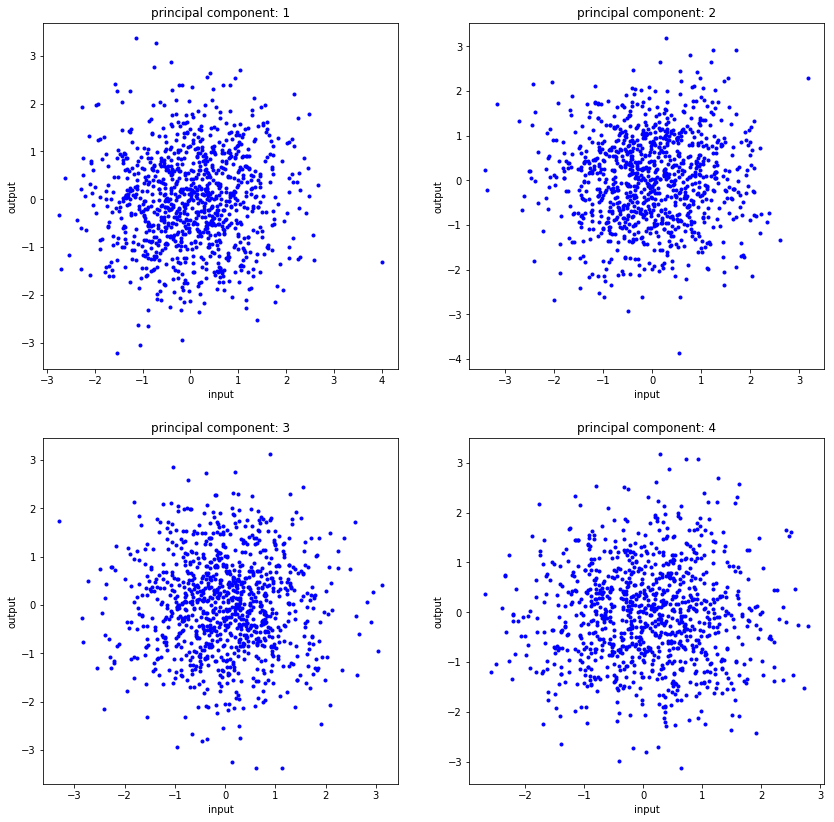

In [41]:
# Sample N points from Gaussian to be projected along principal component
N = 1000
mu, sigma = 0, 1 
w = np.random.normal(mu, sigma, size=(N, d, 2))

plt.figure(figsize=(14, 14))

for pca_i in range(1,5):
    # Fetch eigenvalue and eigenvector as explained variance and pca component
    lambda_i = pca.explained_variance_ratio_[pca_i-1]
    v_i = pca.components_[pca_i-1]

    # Project into 2 dimensions
    w_proj = np.matmul(v_i, w)

    # Plot random projections
    plt.subplot(220+pca_i)
    plt.plot(w_proj[:,0], w_proj[:,1], 'b.')
    plt.xlabel('input')
    plt.ylabel('output')
    plt.title('principal component: ' + str(pca_i))
    
plt.show()

## Plot PCA transformation

In [59]:
# Fetch eigenvalue and eigenvector as explained variance and pca component
pca_i = 1
lambda_1 = pca.explained_variance_ratio_[pca_i-1]
v_1 = pca.components_[pca_i-1]

print(lambda_1)
print(v_1)

# Compute A matrix
A = np.matmul(B, v_1)
A_inv = np.matmul(B, -v_1)
print(A)

0.493759472852
[ 0.66639099  0.17316531  0.08013597 -0.08466051 -0.24480166  0.2014274
  0.16183226  0.2500938   0.14601247  0.43700633  0.33289043]
[ 0.7823859   0.06635446  0.10284883  0.13430817  0.13135864  0.1286062
  0.17081534  0.11676919  0.13940249  0.12933433  0.18745218  0.10530949
  0.1696108   0.11601432  0.19072872  0.10123177  0.22025437  0.07761125
  0.21307244  0.08407499]


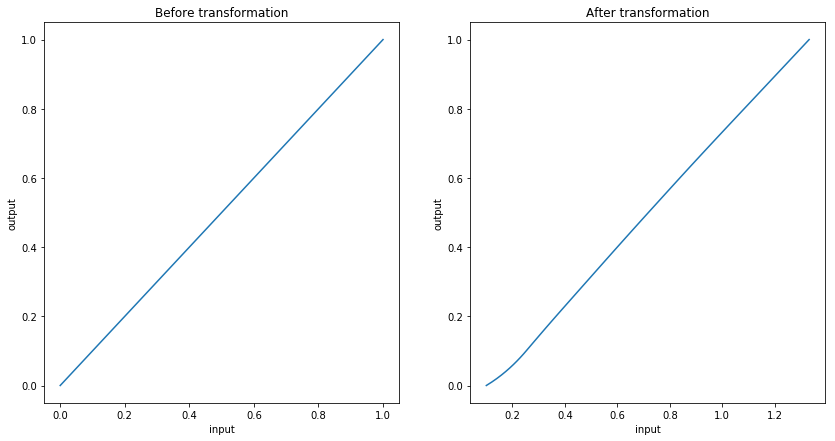

In [60]:
# Transformation plotted
x = np.linspace(0,1,100)
y = x

# Transform input axis
N_step = 100
x_trans = transformation_v1(tess, A, x, N_step, N_p)

# Plot before and after transformation
plt.figure(figsize=(14, 7))
# Before
plt.subplot(121)
plt.plot(x, y)
plt.xlabel('input')
plt.ylabel('output')
plt.title('Before transformation')
# After
plt.subplot(122)
plt.plot(x_trans, y)
plt.xlabel('input')
plt.ylabel('output')
plt.title('After transformation')

#plt.savefig("before_after_CPAB.png")
plt.show()

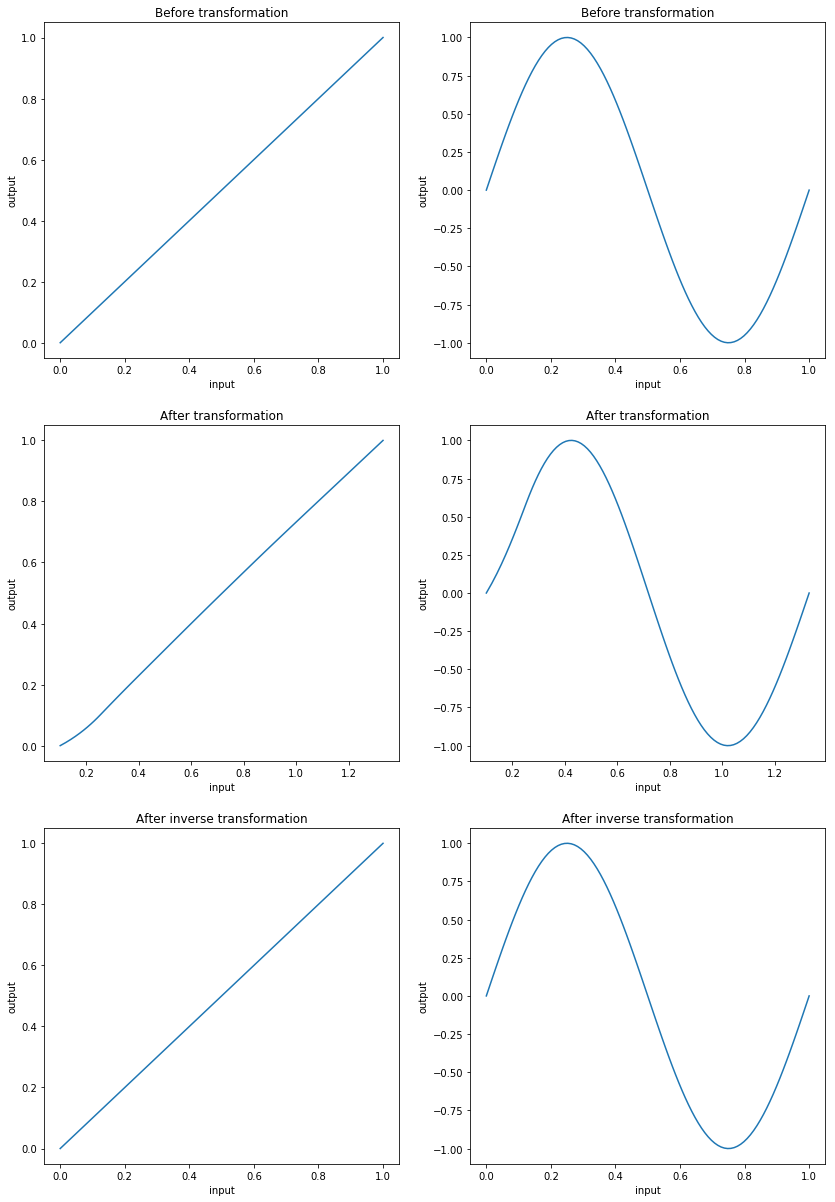

In [61]:
# Transformation and Transformation inverse plotted (also sine curve)
x = np.linspace(0,1,100)
y = x
y_sin = np.sin(2*math.pi*x)

# Transform input axis
x_trans = transformation_v1(tess, A, x, N_step, N_p)

# Inverse transform back to original data
z = transformation_v1(tess, A_inv, x_trans, N_step, N_p)

# Plot before and after inverse transformation
plt.figure(figsize=(14, 21))
# Before
plt.subplot(321)
plt.plot(x, y)
plt.xlabel('input')
plt.ylabel('output')
plt.title('Before transformation')

plt.subplot(322)
plt.plot(x, y_sin)
plt.xlabel('input')
plt.ylabel('output')
plt.title('Before transformation')

# After
plt.subplot(323)
plt.plot(x_trans, y)
plt.xlabel('input')
plt.ylabel('output')
plt.title('After transformation')

plt.subplot(324)
plt.plot(x_trans, y_sin)
plt.xlabel('input')
plt.ylabel('output')
plt.title('After transformation')

# After inverse
plt.subplot(325)
plt.plot(z, y)
plt.xlabel('input')
plt.ylabel('output')
plt.title('After inverse transformation')

plt.subplot(326)
plt.plot(z, y_sin)
plt.xlabel('input')
plt.ylabel('output')
plt.title('After inverse transformation')

plt.show()